In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew
import warnings
warnings.filterwarnings(action = 'ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
%%capture
!pip install dataprep

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/DS105/Data_Tiki.xlsx')

# I. **Làm sạch dữ liệu**

## **1. Data Overview**

DataPrep Report
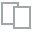
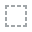
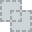
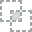
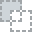
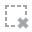
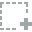
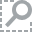
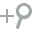
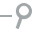
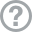
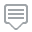
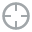
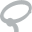
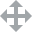
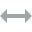
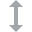
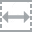
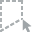
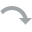
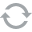
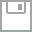
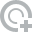
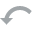
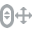
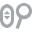
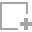
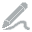
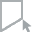
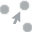
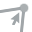
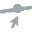

In [ ]:
from dataprep.eda import create_report
create_report(df)

## **2. Cleaning Data**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1916 entries, 0 to 1915
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Unnamed: 0         1916 non-null   int64         
 1   Product ID         1916 non-null   int64         
 2   Name               1916 non-null   object        
 3   Link Product       1916 non-null   object        
 4   Store              1916 non-null   object        
 5   Price              1916 non-null   int64         
 6   Original Price     1916 non-null   int64         
 7   Discount           1916 non-null   int64         
 8   Discount Rate      1916 non-null   int64         
 9   Rating             1916 non-null   float64       
 10  Review Count       1916 non-null   int64         
 11  Type               1916 non-null   object        
 12  Quantity Sold      1885 non-null   float64       
 13  Has Book           1916 non-null   bool          
 14  Author N

## **2.1. Datetime**

In [ ]:
df['Publication Date'] = pd.to_datetime(df['Publication Date'])
df['Publication Date'].fillna(method='bfill', inplace=True)

In [ ]:
# Drop columns has constant values
df.drop(['Unnamed: 0', 'is_authentic', 'has_buynow', 'stock_item', 'Has Book', 'gift_item_title'], axis = 1, inplace = True)

## **2.2. Numerical Data**

In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

In [ ]:
df_num = df._get_numeric_data()
df_num.isna().sum()

Product ID        0  
Price             0  
Original Price    0  
Discount          0  
Discount Rate     0  
Rating            0  
Review Count      0  
Quantity Sold     31 
Number of page    451
dtype: int64

In [ ]:
df_num['Number of page'].fillna(df_num['Number of page'].mean(), inplace = True)
df_num['Quantity Sold'].fillna(df_num['Quantity Sold'].mean(), inplace = True)

In [ ]:
df_num.isna().sum()

Product ID        0
Price             0
Original Price    0
Discount          0
Discount Rate     0
Rating            0
Review Count      0
Quantity Sold     0
Number of page    0
dtype: int64


## **2.3. Tạo thêm features mới từ features đã có**






### **2.3.1. Chuyển biến Price về biến phân loại tên là Range Price có giá theo từ thấp đến cao theo 5 mức:**
*   Mức 1: dưới 50.000
*   Mức 2: từ 50.000 đến 100.000
*   Mức 3: từ 100.000 đến 150.000
*   Mức 4: từ 150.000 đến 200.000
*   Mức 5: trên 200.000

In [ ]:
group_name = ['Mức 1', 'Mức 2', 'Mức 3','Mức 4', 'Mức 5']
bins = [0, 50000, 100000, 150000, 200000, df.Price.max()]
bins

[0, 50000, 100000, 150000, 200000, 1400000]

In [ ]:
df_num['Range Price'] = pd.cut(df_num.Price, bins, labels = group_name, include_lowest = True)

### **2.3.2. Lấy năm xuất bản dựa trên biến Publication Date**

In [ ]:
def Year(date_):
  if date_ is not np.nan:
    return date_.year
  else:
    return 0
df['Publication Year'] = df['Publication Date'].apply(lambda x: Year(x))
df['Publication Year'] = df['Publication Year'].astype(float)

## **2.4. Categorical Data**

In [ ]:
df_categorical = df.select_dtypes(include = 'object')
df_categorical.isna().sum()

Name                 0   
Link Product         0   
Store                0   
Type                 0   
Author Name          365 
Short Description    0   
Publisher            141 
Dimensions           589 
Translators          1083
Categories           0   
dtype: int64

In [ ]:
import re
def extract_size(text):
    text = text.replace('<p>', '').replace('</p>', '').replace(',', '.').replace('×','x')

    pattern = r'(?:Kích thước: (\d+\s*x\s*\d+\s*x\s*\d+(?:,\d+)?\s*cm))|(?:\b(\d+(?:[.,]\d+)?\s*x\s*\d+(?:[.,]\d+)?\s*cm)\b)|(?:<p>(\d+\s*x\s*\d+\s*cm)</p>)|(?:<p>(\d+\s*X\s*\d+\s*cm)</p>)|(Chiều dài (\d+)\s*cm.*?Chiều rộng (\d+)\s*cm.*?Chiều cao (\d+)\s*cm)'
    match = re.search(pattern, text)
    if match:
        if match.group(1) or match.group(2):
            return match.group(1) or match.group(2)
        else:
            length = match.group(6)
            width = match.group(7)
            height = match.group(8)
            return f"{length} x {width} x {height} cm"
    else:
        return text


def preprocess_cate(df_categorical):
  # Filling misssing values
  df_categorical['Publisher'].fillna('Others', inplace = True)
  df_categorical['Translators'].fillna('Unknown', inplace = True)
  df_categorical['Author Name'].fillna('Unknown', inplace = True)

  # Process and cleaning data
  df_categorical['Dimensions'] = df_categorical['Dimensions'].apply(lambda x: extract_size(x) if isinstance(x, str) else None)
  df_categorical['Dimensions'].fillna(method = 'bfill', inplace = True)
  df_categorical['Dimensions'] = df_categorical['Dimensions'].str.lower()
  df_categorical[['Width', 'Length', 'Height']] = df_categorical['Dimensions'].str.split('x',expand = True)
  df_categorical['Width'] = df_categorical['Width'].replace('1 cuốn sách',0)
  df_categorical['Width'] = df_categorical['Width'].str.split('cm').str[0]
  df_categorical['Width'] = df_categorical['Width'].str.split('mm').str[0].astype(float)

  df_categorical['Height'].fillna('0', inplace = True)
  df_categorical['Length'].fillna('0', inplace = True)
  df_categorical['Length'] = df_categorical['Length'].str.split('cm').str[0].astype(float)
  df_categorical['Height'] = df_categorical['Height'].str.split('cm').str[0]
  df_categorical['Height'] = df_categorical['Height'].str.split('mm').str[0].astype(float)

  df_categorical['Translators'] = df_categorical['Translators'].astype(str)
  df_categorical['Type'] = df_categorical['Type'].astype(str)
  df_categorical['Publisher'] = df_categorical['Publisher'].astype(str)
  df_categorical['Categories'] = df_categorical['Categories'].astype(str)

  df_categorical.drop(['Dimensions'], axis = 1, inplace = True)

  df_categorical['Width'].fillna(0, inplace = True)


  return df_categorical
df_categorical = preprocess_cate(df_categorical)

In [ ]:
df_categorical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1916 entries, 0 to 1915
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               1916 non-null   object 
 1   Link Product       1916 non-null   object 
 2   Store              1916 non-null   object 
 3   Type               1916 non-null   object 
 4   Author Name        1916 non-null   object 
 5   Short Description  1916 non-null   object 
 6   Publisher          1916 non-null   object 
 7   Translators        1916 non-null   object 
 8   Categories         1916 non-null   object 
 9   Width              1916 non-null   float64
 10  Length             1916 non-null   float64
 11  Height             1916 non-null   float64
dtypes: float64(3), object(9)
memory usage: 179.8+ KB


In [ ]:
df_categorical.isna().sum()

Name                 0
Link Product         0
Store                0
Type                 0
Author Name          0
Short Description    0
Publisher            0
Translators          0
Categories           0
Width                0
Length               0
Height               0
dtype: int64

## **2.5. Save file data cleaned!**

In [ ]:
clean_data = pd.concat([df_categorical, df_num, df[['Publication Date', 'Publication Year']]], axis=1)
clean_data.to_csv('/content/drive/MyDrive/DS challenge/data_cleaned.csv', index = False)
clean_data.head()

Name  \
0  Kế Toán Vỉa Hè - Thực Hành Báo Cáo Tài Chính Căn Bản Từ Quầy Bán Nước Chanh                                                                              
1  Mùa hè không tên (Nguyễn Nhật Ánh) - Tặng kèm Bookmark, Tranh màu, Sổ note cho cả 2 phiên bản - Tặng thêm ngẫu nhiên 1 trong 2 Lót ly cho Bản bìa cứng   
2  Không Diệt Không Sinh Đừng Sợ Hãi (TB5)                                                                                                                  
3  Cây Cam Ngọt Của Tôi                                                                                                                                     
4  Nghệ Thuật Tư Duy Chiến Lược                                                                                                                             

                                                                                                               Link Product  \
0  https://tiki.vn/ke-toan-via-he-thuc-hanh-bao-cao-tai-chinh-can-ban-tu-quay-ban-nuoc-chanh-p262977989.html?spid=262977990   
1  https://tiki.vn/mua-he-khong-ten-nguyen-nhat-anh-p271916321.html?spid=271916323                                            
2  https://tiki.vn/khong-diet-khong-sinh-dung-so-hai-tb5-p187827003.html?spid=187827005                                       
3  https://tiki.vn/cay-cam-ngot-cua-toi-p74021317.html?spid=74677933                                                          
4  https://tiki.vn/nghe-thuat-tu-duy-chien-luoc-p12138656.html?spid=20479537                                                  

             Store          Type                          Author Name  \
0  GIVER Books      simple        Unknown                               
1  Tiki Trading     configurable  Nguyễn Nhật Ánh                       
2  Tiki Trading     simple        Thích Nhất Hạnh                       
3  Nhà sách Fahasa  simple        José Mauro de Vasconcelos             
4  Nhà sách Fahasa  simple        Avinash K. Dixit, Barry J. Nalebuff   

                                                                                                                                                                                             Short Description  \
0  BIẾN KẾ TOÁN KHÔ KHAN TRỞ THÀNH TRÒ CHƠI CON TRẺ, DỄ HIỂU VÀ DỄ ÁP DỤNGĐã bao lần bạn cầm trên tay bảng báo cáo tài chính doanh nghiệp của mình, nhưng chẳng thể nào hiểu nổi? Kế toán và tài chính là...     
1  “Mùa hè không tên” là truyện dài mới nhất của nhà văn Nguyễn Nhật Ánh, với những câu chuyện tuổi thơ với vô số trò tinh nghịch, những thoáng thinh thích hồi hộp cùng vô vàn kỷ niệm. Để rồi khi những t...   
2  Nhiều người trong chúng ta tin rằng cuộc đời của ta bắt đầu từ lúc chào đời và kết thúc khi ta chết. Chúng ta tin rằng chúng ta tới từ cái Không, nên khi chết chúng ta cũng không còn lại gì hết. Và ch...   
3  “Vị chua chát của cái nghèo hòa trộn với vị ngọt ngào khi khám phá ra những điều khiến cuộc đời này đáng số một tác phẩm kinh điển của Brazil.”- Booklist“Một cách nhìn cuộc sống gần như hoàn chỉnh t...     
4  Có phải những người chiến thắng các chương trình truyền hình thực tế được trời phú cho trí thông minh và kỹ năng hơn người?Có phải các nhà đầu tư vĩ đại có thể nhìn thấy những điều mà hầu hết mọi ngư...    

                         Publisher                  Translators                  Categories  \
0  Công ty TNHH Truyền Thông Giver  Trần Thanh Phong             Sách tài chính, kế toán      
1  NXB Trẻ                          Unknown                      Truyện dài                   
2  Saigon Books                     Unknown                      Sách tư duy - Kỹ năng sống   
3  Nhã Nam                          Nguyễn Bích Lan , Tô Yến Ly  Sách tiếng Việt              
4  Alphabooks                       Kim Phúc                     Sách tiếng Việt              

   Width  Length  Height  Product ID   Price  Original Price  Discount  Discount Rate  Rating  \
0  13.0   20.0    0.0     262977989   169000  199000          30000     15 

In [ ]:
clean_data.isna().sum()

Name                 0
Link Product         0
Store                0
Type                 0
Author Name          0
Short Description    0
Publisher            0
Translators          0
Categories           0
Width                0
Length               0
Height               0
Product ID           0
Price                0
Original Price       0
Discount             0
Discount Rate        0
Rating               0
Review Count         0
Quantity Sold        0
Number of page       0
Range Price          0
Publication Date     0
Publication Year     0
dtype: int64

# II. **Phân tích thăm dò**

## Thống kê cơ bản

In [ ]:
num_rows, num_cols = clean_data.shape
print(f"Số dòng: {num_rows}")
print(f"Số cột: {num_cols}")
missing_data = clean_data.isnull().sum()
print("Dữ liệu thiếu:")
print(missing_data)

print(clean_data.dtypes)
description = clean_data.describe()
print("Thống kê mô tả:")
description


Số dòng: 1916
Số cột: 24
Dữ liệu thiếu:
Name                 0
Link Product         0
Store                0
Type                 0
Author Name          0
Short Description    0
Publisher            0
Translators          0
Categories           0
Width                0
Length               0
Height               0
Product ID           0
Price                0
Original Price       0
Discount             0
Discount Rate        0
Rating               0
Review Count         0
Quantity Sold        0
Number of page       0
Range Price          0
Publication Date     0
Publication Year     0
dtype: int64
Name                 object        
Link Product         object        
Store                object        
Type                 object        
Author Name          object        
Short Description    object        
Publisher            object        
Translators          object        
Categories           object        
Width                float64       
Length               float64       

Width       Length       Height    Product ID         Price  Original Price  \
count  1916.000000  1916.000000  1916.000000  1.916000e+03  1.916000e+03  1.916000e+03     
mean   15.120042    21.222860    0.097704     1.507035e+08  1.231184e+05  1.568408e+05     
std    10.117014    8.472332     1.134774     9.202299e+07  1.002786e+05  1.254203e+05     
min    0.000000     0.000000     0.000000     3.473340e+05  1.900000e+03  2.000000e+03     
25%    13.000000    20.000000    0.000000     6.858176e+07  6.800000e+04  8.800000e+04     
50%    14.000000    20.500000    0.000000     1.686108e+08  1.010500e+05  1.290000e+05     
75%    15.500000    23.000000    0.000000     2.474436e+08  1.490000e+05  1.950000e+05     
max    277.000000   224.000000   25.000000    2.723548e+08  1.400000e+06  1.750000e+06     

            Discount  Discount Rate       Rating  Review Count  Quantity Sold  Number of page  \
count  1916.000000    1916.000000    1916.000000  1916.000000   1916.000000    1916.000000      
mean   33722.395616   20.134656      4.389979     157.037056    1370.416976    408.578840       
std    36644.433310   12.092189      1.479180     465.082421    4476.859897    2808.392068      
min    0.000000       0.000000       0.000000     0.000000      1.000000       10.000000        
25%    9575.000000    12.000000      4.800000     4.000000      69.750000      227.500000       
50%    26400.000000   22.000000      5.000000     24.500000     257.000000     342.000000       
75%    46000.000000   29.000000      5.000000     99.250000     934.000000     408.578840       
max    403000.000000  70.000000      5.000000     7087.000000   79536.000000   123000.000000    

       Publication Year  
count  1916.000000       
mean   2021.006263       
std    1.876601          
min    2001.000000       
25%    2020.000000       
50%    2021.000000       
75%    2022.000000       
max    2023.000000

## 1. Phân tích tổng quan (Short Analysis)

In [ ]:
df1 = clean_data.copy()

In [ ]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
def convert_categorical_var(df):
  le = LabelEncoder()

  categorical_var = ['Store', 'Type', 'Author Name','Publisher',
       'Translators', 'Categories', 'Range Price']

  for col in categorical_var:
    df[col] = le.fit_transform(df[col])
  return df


df1 = convert_categorical_var(df1)
df1.head()

Name  \
0  Kế Toán Vỉa Hè - Thực Hành Báo Cáo Tài Chính Căn Bản Từ Quầy Bán Nước Chanh                                                                              
1  Mùa hè không tên (Nguyễn Nhật Ánh) - Tặng kèm Bookmark, Tranh màu, Sổ note cho cả 2 phiên bản - Tặng thêm ngẫu nhiên 1 trong 2 Lót ly cho Bản bìa cứng   
2  Không Diệt Không Sinh Đừng Sợ Hãi (TB5)                                                                                                                  
3  Cây Cam Ngọt Của Tôi                                                                                                                                     
4  Nghệ Thuật Tư Duy Chiến Lược                                                                                                                             

                                                                                                               Link Product  \
0  https://tiki.vn/ke-toan-via-he-thuc-hanh-bao-cao-tai-chinh-can-ban-tu-quay-ban-nuoc-chanh-p262977989.html?spid=262977990   
1  https://tiki.vn/mua-he-khong-ten-nguyen-nhat-anh-p271916321.html?spid=271916323                                            
2  https://tiki.vn/khong-diet-khong-sinh-dung-so-hai-tb5-p187827003.html?spid=187827005                                       
3  https://tiki.vn/cay-cam-ngot-cua-toi-p74021317.html?spid=74677933                                                          
4  https://tiki.vn/nghe-thuat-tu-duy-chien-luoc-p12138656.html?spid=20479537                                                  

   Store  Type  Author Name  \
0  35     1     953           
1  141    0     631           
2  141    1     867           
3  86     1     428           
4  86     1     73            

                                                                                                                                                                                             Short Description  \
0  BIẾN KẾ TOÁN KHÔ KHAN TRỞ THÀNH TRÒ CHƠI CON TRẺ, DỄ HIỂU VÀ DỄ ÁP DỤNGĐã bao lần bạn cầm trên tay bảng báo cáo tài chính doanh nghiệp của mình, nhưng chẳng thể nào hiểu nổi? Kế toán và tài chính là...     
1  “Mùa hè không tên” là truyện dài mới nhất của nhà văn Nguyễn Nhật Ánh, với những câu chuyện tuổi thơ với vô số trò tinh nghịch, những thoáng thinh thích hồi hộp cùng vô vàn kỷ niệm. Để rồi khi những t...   
2  Nhiều người trong chúng ta tin rằng cuộc đời của ta bắt đầu từ lúc chào đời và kết thúc khi ta chết. Chúng ta tin rằng chúng ta tới từ cái Không, nên khi chết chúng ta cũng không còn lại gì hết. Và ch...   
3  “Vị chua chát của cái nghèo hòa trộn với vị ngọt ngào khi khám phá ra những điều khiến cuộc đời này đáng số một tác phẩm kinh điển của Brazil.”- Booklist“Một cách nhìn cuộc sống gần như hoàn chỉnh t...     
4  Có phải những người chiến thắng các chương trình truyền hình thực tế được trời phú cho trí thông minh và kỹ năng hơn người?Có phải các nhà đầu tư vĩ đại có thể nhìn thấy những điều mà hầu hết mọi ngư...    

   Publisher  Translators  Categories  Width  Length  Height  Product ID   Price  Original Price  \
0  63         516          99          13.0   20.0    0.0     262977989   169000  199000           
1  118        553          120         13.0   20.0    0.0     271916321   109000  130000           
2  164        553          101         14.0   20.5    0.0     187827003   76000   110000           
3  148        271          98          14.0   20.5    0.0     74021317    75600   108000           
4  5          172          98          16.0   24.0    0.0     12138656    174500  239000           

   Discount  Discount Rate  Rating  Review Count  Quantity Sold  Number of page  Range Price  \
0  30000     15             5.0     111           5990.0         268.0           3             
1  21000     16             4.8     141           1715.0         292.0           2             
2  34000     31             5.0     1481          21867.0        224.0           1             
3  32400  

## 1.1.1. Correlation Matrix

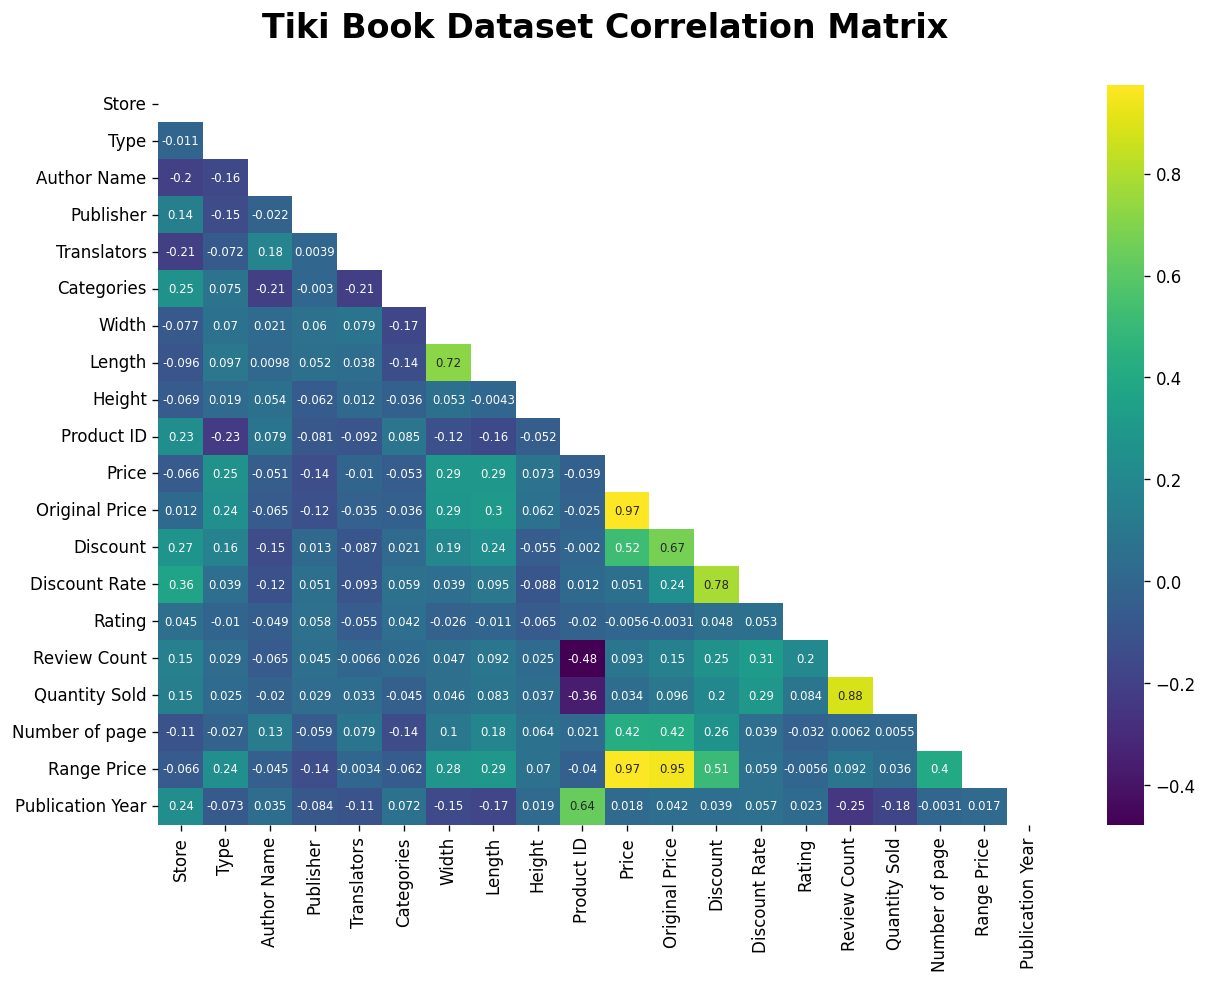

In [ ]:
def heatmap(dataset, label = None):
    corr = dataset.corr(method = 'spearman')
    plt.figure(figsize = (12, 8), dpi = 120)
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(corr, mask = mask, cmap = 'viridis', annot = True, annot_kws = {'size' : 7})
    plt.title(f'{label} Dataset Correlation Matrix\n', fontsize = 20, weight = 'bold')
    plt.show()

heatmap(df1, 'Tiki Book')

Nhận xét:

*   Ba cặp biến có độ tương quan cao nhất là 'Price' và 'Range Price', 'Price' và 'Original Price', 'Original Price' và 'Range Price' vì đều thể hiện giá sản phẩm.
*   Cặp biến tương quan xếp sau những cặp trên là 'Review Count' và 'Quantity Sold', chứng tỏ càng có nhiều lượt mua thì càng có nhiều lượt bình luận.



In [ ]:
DR_corr = pd.DataFrame(df.corr().iloc[4].sort_values(ascending = False))

In [ ]:
DR_corr

Discount Rate
Discount Rate     1.000000     
Discount          0.589479     
Rating            0.154986     
Original Price    0.140150     
Quantity Sold     0.111198     
Review Count      0.108113     
Publication Year  0.049600     
Number of page    0.020482     
Product ID        0.001964     
Price            -0.040122

In [ ]:
DR_corr.to_excel('corr_DR.xlsx', index = False)

In [ ]:
def find_correlated_features_numeric(df, target):
    df_num_corr = df.corr()[target]
    correlated_features = df_num_corr[abs(df_num_corr) > -10].sort_values(ascending=False)
    return correlated_features
find_correlated_features_numeric(df1, 'Discount Rate')

Discount Rate       1.000000
Discount            0.589479
Store               0.337201
Rating              0.154986
Original Price      0.140150
Categories          0.112541
Quantity Sold       0.111198
Review Count        0.108113
Publisher           0.061431
Publication Year    0.049600
Length              0.039079
Type                0.034247
Range Price         0.022370
Number of page      0.020482
Width               0.006422
Product ID          0.001964
Price              -0.040122
Height             -0.053628
Translators        -0.082547
Author Name        -0.103563
Name: Discount Rate, dtype: float64

## 1.1.2. Central Tendency

In [ ]:
df1.describe()

Store         Type  Author Name    Publisher  Translators   Categories        Width  \
count  1916.000000  1916.000000  1916.000000  1916.000000  1916.000000  1916.000000  1916.000000   
mean   107.598643   0.884134     611.029749   110.041754   445.143528   85.769311    15.120042     
std    41.188824    0.320148     316.738819   59.460133    170.140258   31.338779    10.117014     
min    0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000      
25%    86.000000    1.000000     332.750000   71.750000    355.000000   66.000000    13.000000     
50%    139.000000   1.000000     653.500000   118.000000   553.000000   98.000000    14.000000     
75%    141.000000   1.000000     953.000000   150.000000   553.000000   101.000000   15.500000     
max    173.000000   1.000000     1049.000000  212.000000   618.000000   140.000000   277.000000    

            Length       Height    Product ID         Price  Original Price       Discount  \
count  1916.000000  1916.000000  1.916000e+03  1.916000e+03  1.916000e+03    1916.000000     
mean   21.222860    0.097704     1.507035e+08  1.231184e+05  1.568408e+05    33722.395616    
std    8.472332     1.134774     9.202299e+07  1.002786e+05  1.254203e+05    36644.433310    
min    0.000000     0.000000     3.473340e+05  1.900000e+03  2.000000e+03    0.000000        
25%    20.000000    0.000000     6.858176e+07  6.800000e+04  8.800000e+04    9575.000000     
50%    20.500000    0.000000     1.686108e+08  1.010500e+05  1.290000e+05    26400.000000    
75%    23.000000    0.000000     2.474436e+08  1.490000e+05  1.950000e+05    46000.000000    
max    224.000000   25.000000    2.723548e+08  1.400000e+06  1.750000e+06    403000.000000   

       Discount Rate       Rating  Review Count  Quantity Sold  Number of page  Range Price  \
count  1916.000000    1916.000000  1916.000000   1916.000000    1916.000000     1916.000000   
mean   20.134656      4.389979     157.037056    1370.416976    408.578840      1.727035      
std    12.092189      1.479180     465.082421    4476.859897    2808.392068     1.220846      
min    0.000000       0.000000     0.000000      1.000000       10.000000       0.000000      
25%    12.000000      4.800000     4.000000      69.750000      227.500000      1.000000      
50%    22.000000      5.000000     24.500000     257.000000     342.000000      2.000000      
75%    29.000000      5.000000     99.250000     934.000000     408.578840      2.000000      
max    70.000000      5.000000     7087.000000   79536.000000   123000.000000   4.000000      

       Publication Year  
count  1916.000000       
mean   2021.006263       
std    1.876601          
min    2001.000000       
25%    2020.000000       
50%    2021.000000       
75%    2022.000000       
max    2023.000000

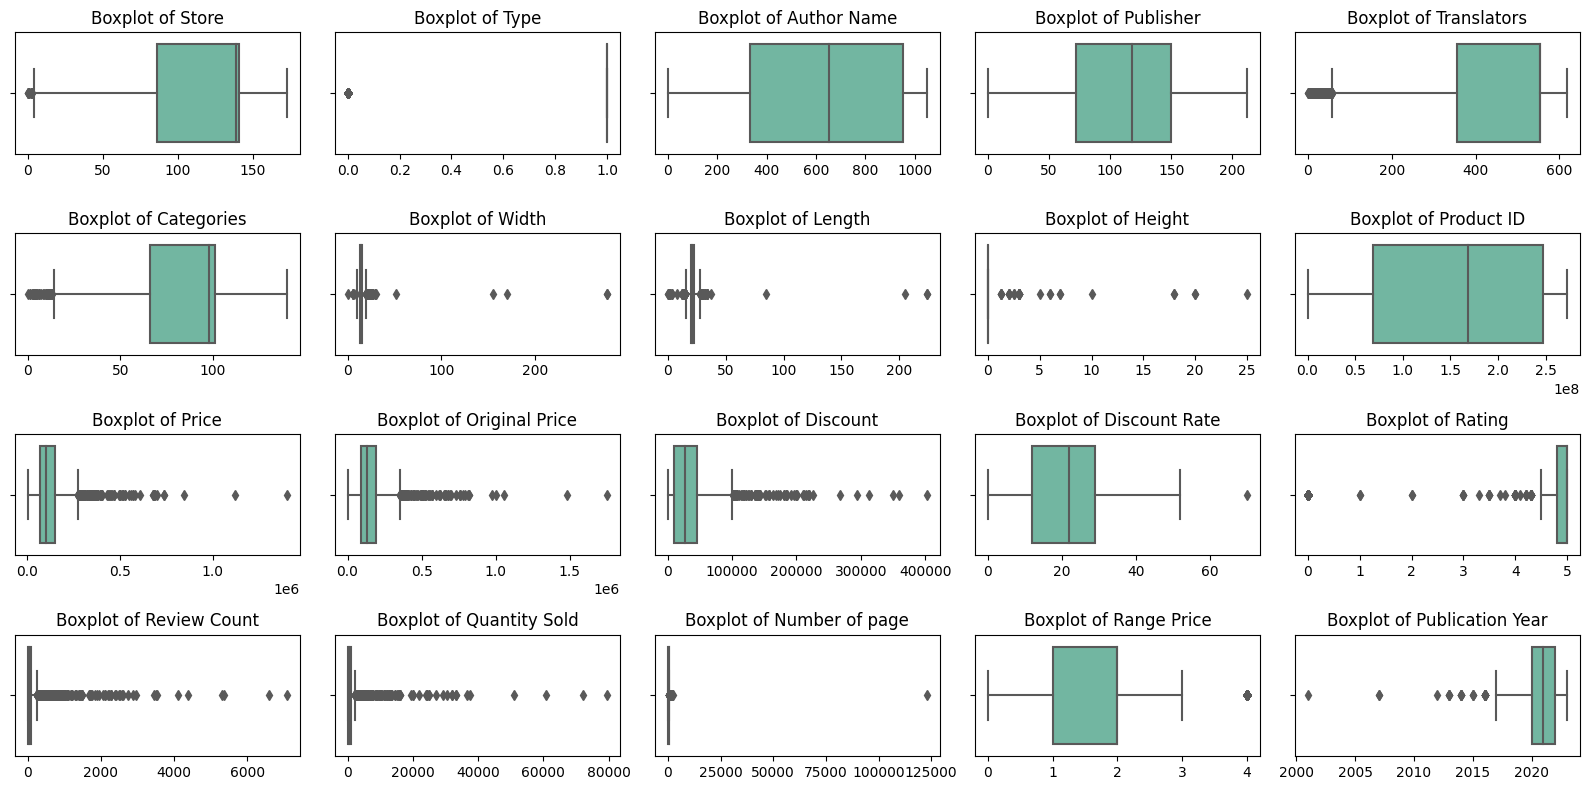

In [ ]:
numerical_columns = df1._get_numeric_data()

num_plots = len(numerical_columns.columns)
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(16, 8))
axes = axes.flatten()

for i, col in enumerate(numerical_columns.columns):
    sns.boxplot(x=numerical_columns[col], ax=axes[i], palette='Set2')
    axes[i].set_title(f'Boxplot of {col}')
    axes[i].set_xlabel(None)

for i in range(num_plots, len(axes)):
    axes[i].remove()

plt.tight_layout()
plt.show()


1.   Các biến trong biểu đồ đa số có giá trị ngoại lệ.
2.   Đồ thị của biến 'Original Price', 'Discount Rate' và 'Discount' đang ở trạng thái Positively Skewed.
3.   Đối với biến Rating: giá trị dao động từ khoảng 4.8 đến 5, có giá trị trung vị trùng với giá trị lớn nhất và Negatively Skewed.
4.   Đối với biến Review Count: đồ thị thể hiện Positively Skewed với giá trị ngoại lệ đông đúc.
5.   Đối với biến Quantity Sold đang ở mức Positively Skewed.
6.   Đối với biến Number of page có đồ thị ở Positively Skewed \\
==> Để nhìn thấy được độ lệch rõ nét hơn của các biến đồ thị histplot sẽ được vẽ ở bên dưới.

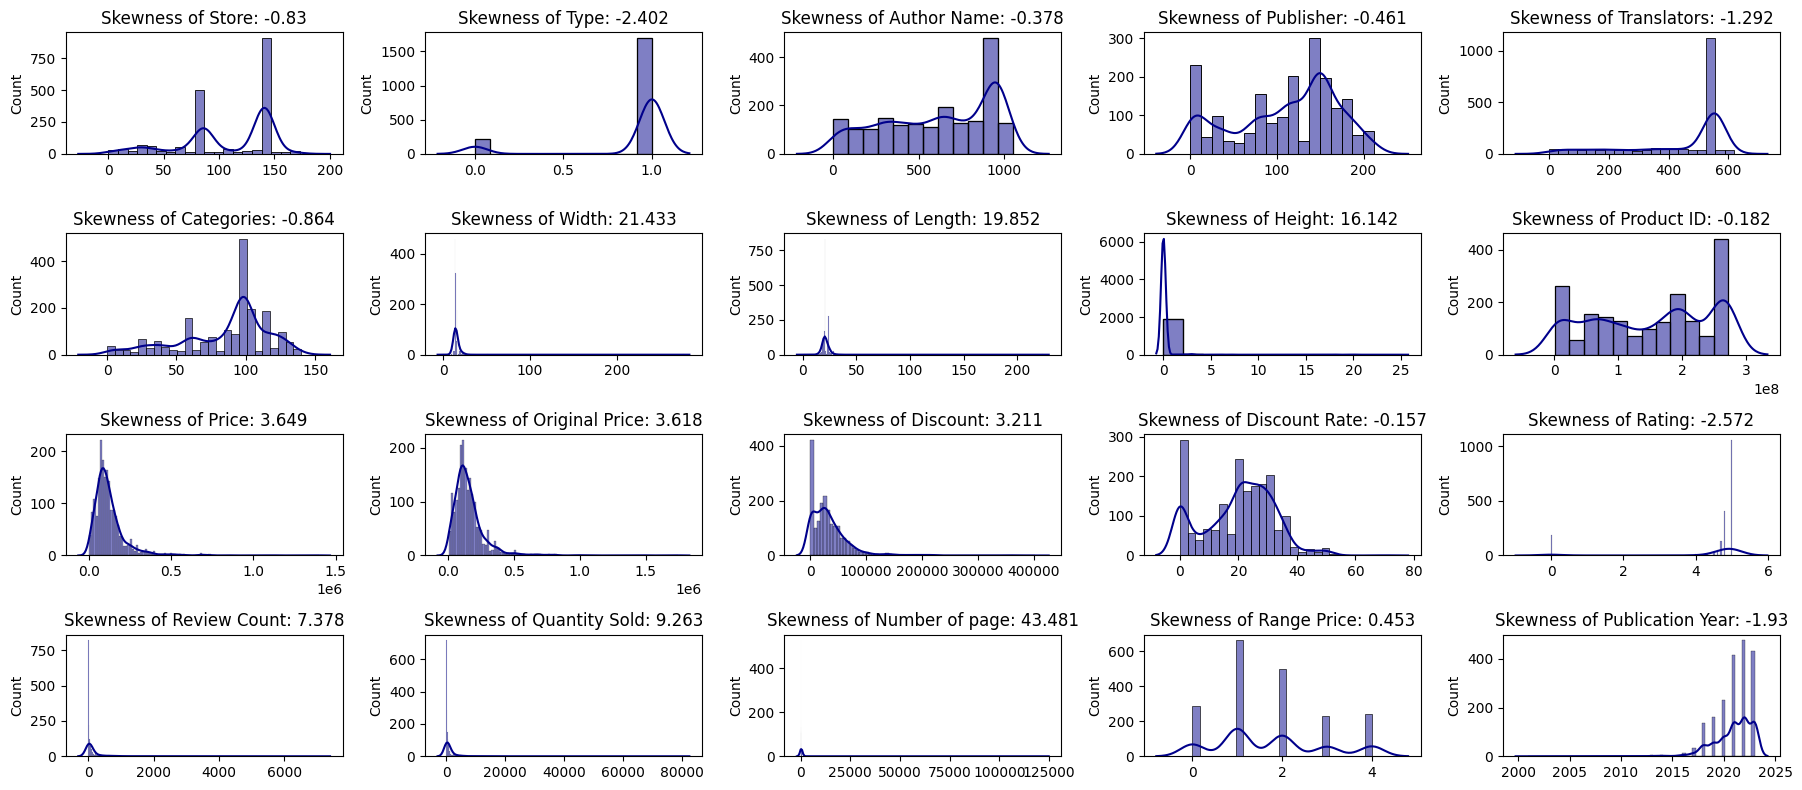

In [ ]:
num_plots = len(numerical_columns.columns)
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(18, 8))
axes = axes.flatten()

for i, col in enumerate(numerical_columns.columns):
    sns.histplot(df1[col], kde=True, color='darkblue', kde_kws=dict(cut=3), ax=axes[i])
    skew_value = round(df1[col].skew(), 3)
    axes[i].set_title(f'Skewness of {col}: {skew_value}')
    axes[i].set_xlabel(None)

for i in range(num_plots, len(axes)):
    axes[i].remove()

plt.tight_layout()
plt.show()

## 1.1.3. Distribution of 'Price', 'Original Price', 'Discount', 'Discount Rate'

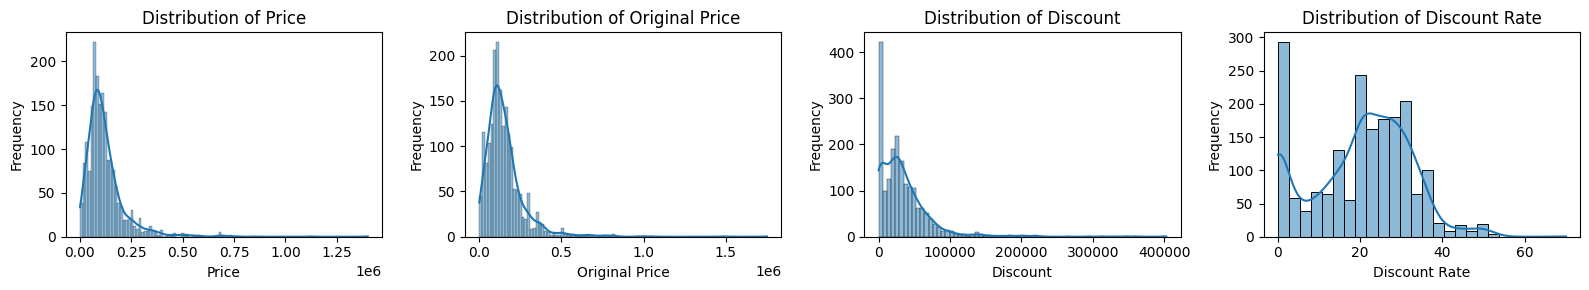

In [ ]:
columns_to_plot = ['Price', 'Original Price', 'Discount', 'Discount Rate']

plt.figure(figsize=(16, 3))
for i, column in enumerate(columns_to_plot, 1):
    plt.subplot(1, 4, i)
    sns.histplot(df1[column], kde=True)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

Nhận xét:



*   Biểu đồ phân bố của Price, Original Price có hình dạng hơi giống nhau
*   Biểu đồ phân bố của Discout và Discount Rate có hình dạng tương tự nhau




## 1.2. Phân tích sâu (Deep Insight Analysis)

In [ ]:
df2 = df.copy()

### Q1: Thống kê số lượng Nhà xuất bản(Publisher), số cửa hàng (Store), số thể loại (Categories), số sản phẩm (Product ID), số tác giả (Author Name) trên Nhà sách Tiki

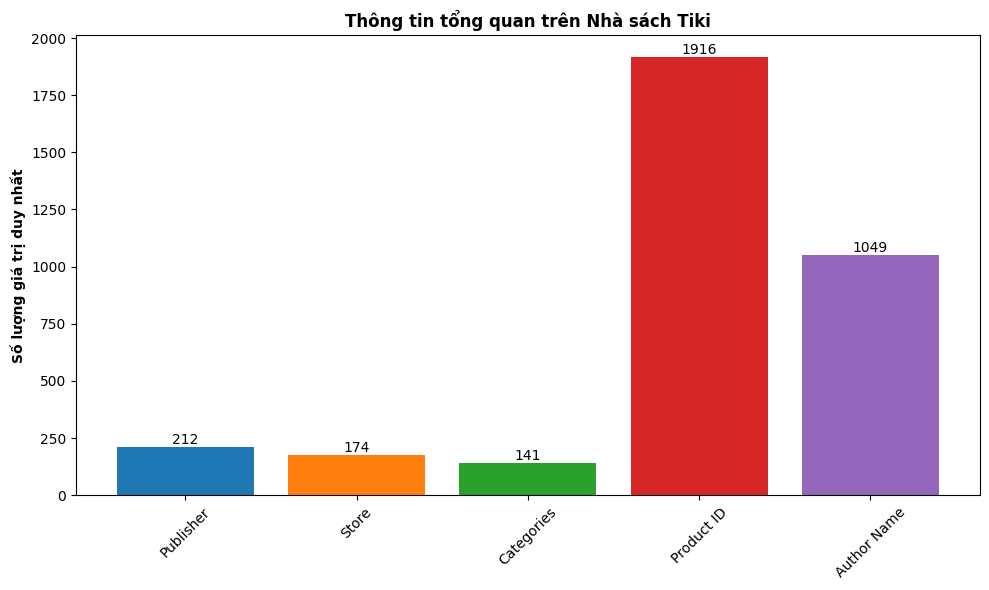

In [ ]:
unique_values_counts = [
    df2['Publisher'].nunique(),
    df2['Store'].nunique(),
    df2['Categories'].nunique(),
    df2['Product ID'].nunique(),
    df2['Author Name'].nunique()
]

columns = ['Publisher', 'Store', 'Categories', 'Product ID', 'Author Name']
colors = plt.cm.tab10(np.arange(len(columns)))

plt.figure(figsize=(10, 6))
bars = plt.bar(columns, unique_values_counts, color=colors)
plt.title('Thông tin tổng quan trên Nhà sách Tiki', fontweight='bold')
# plt.xlabel('', fontweight='bold')
plt.ylabel('Số lượng giá trị duy nhất', fontweight='bold')
plt.xticks(rotation=45)

for bar, value in zip(bars, unique_values_counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.3, value, ha='center', va='bottom')

plt.tight_layout()
plt.show()


**Thông tin tổng quan**
*   Số lượng nhà xuất bản: 213
*   Số lượng cửa hàng phân phối sản phẩm: 174
*   Số lượng thể loại sách: 141
*   Số lượng sản phẩm: 1916
*   Số lượng tác giả: 1050


## 1.2.1. Đánh giá và phân tích các khía cạnh về Nhà xuất bản (Publisher) trên Nhà sách Tiki

### Q2: Top 15 nhà xuất bản nổi bật nhất trên Nhà sách Tiki?

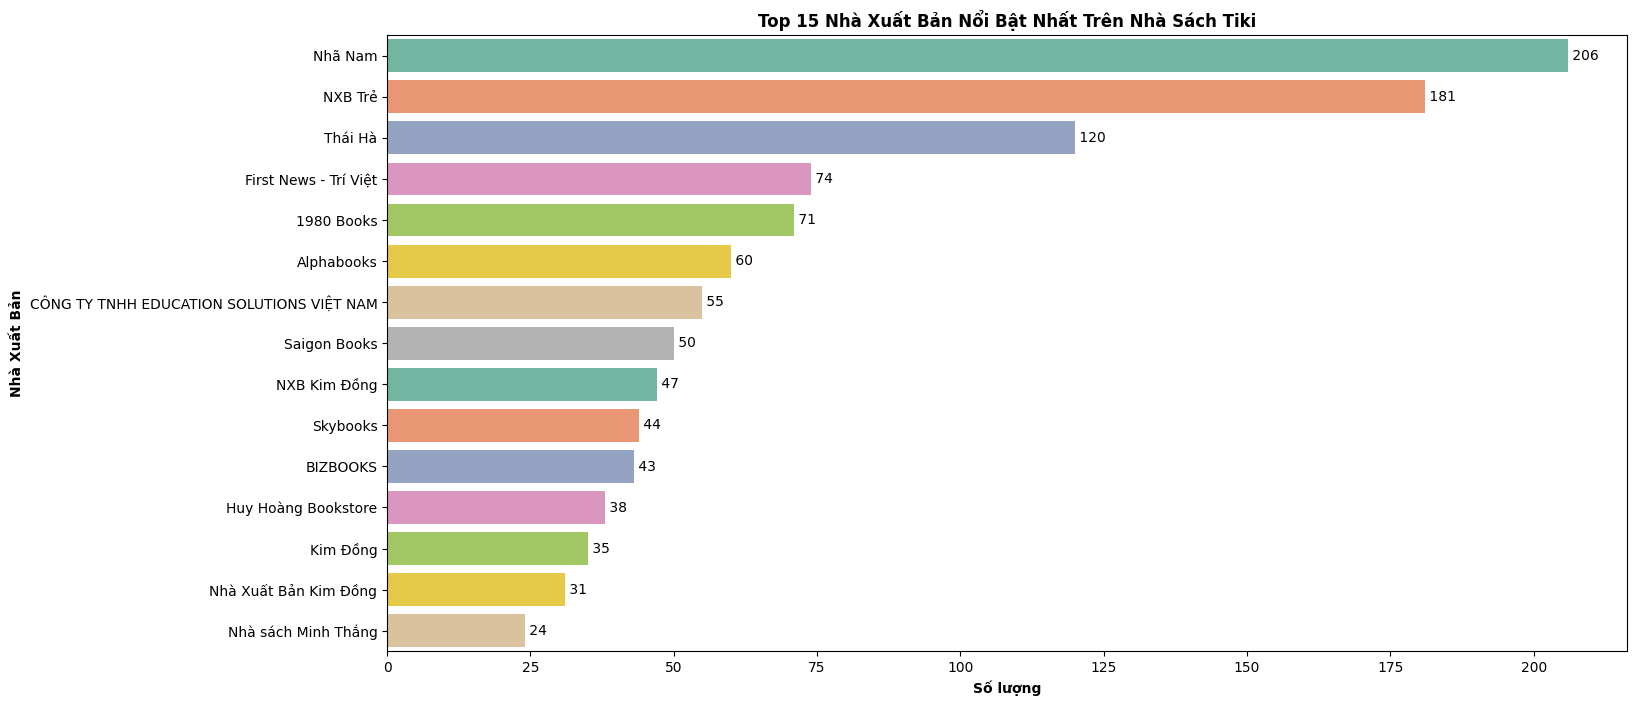

In [ ]:
import random
top_publishers = df['Publisher'].value_counts().head(15).sort_values(ascending=False)
palette = 'Set2'
plt.figure(figsize=(16, 8))
barplot = sns.barplot(x=top_publishers.values, y=top_publishers.index, palette=palette)

for i, val in enumerate(top_publishers.values):
    barplot.text(val, i, f' {val}', ha='left', va='center', color='black')

plt.title('Top 15 Nhà Xuất Bản Nổi Bật Nhất Trên Nhà Sách Tiki', fontweight='bold')
plt.xlabel('Số lượng', fontweight='bold')
plt.ylabel('Nhà Xuất Bản', fontweight='bold')
plt.show()


Nhận xét:

*   Dựa vào thống kê tần suất, ta thấy 2 nhà xuất bản nổi bật nhất trên Nhà sách Tiki là 'Nhã Nam' và 'NXB Trẻ' chiếm thị phần lớn nhất.

### Q3: Đối với 2 nhà xuất bản chiếm thị phần lớn nhất trên Nhà sách Tiki là 'Nhã Nam' và 'NXB Trẻ' có đặc trưng riêng về thể loại sách (Categories) mà họ xuất bản không?

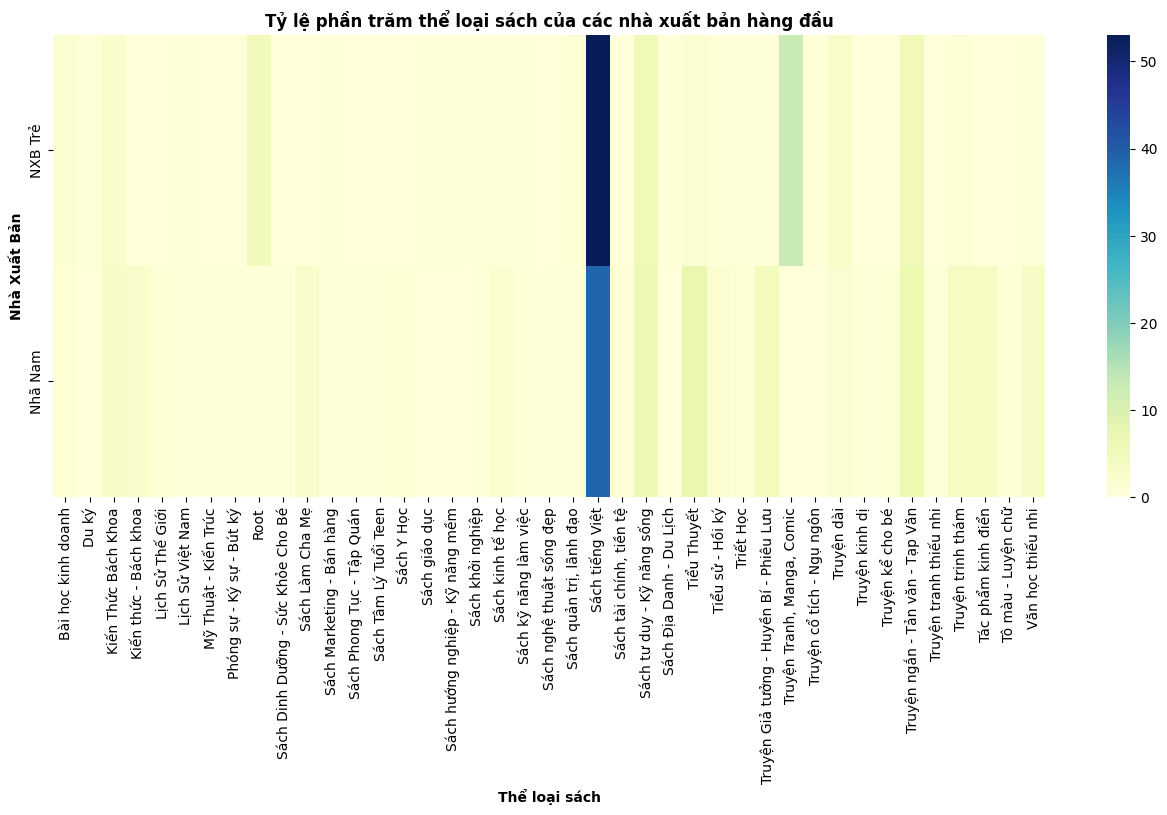

In [ ]:
top_publishers = df2['Publisher'].value_counts().head(2).index
top_publishers_data = df2[df2['Publisher'].isin(top_publishers)]

publisher_genre = top_publishers_data.groupby(['Publisher', 'Categories']).size().unstack(fill_value=0)
publisher_genre_percentage = publisher_genre.div(publisher_genre.sum(axis=1), axis=0) * 100

plt.figure(figsize=(16, 6))
sns.heatmap(publisher_genre_percentage, cmap='YlGnBu')
plt.title('Tỷ lệ phần trăm thể loại sách của các nhà xuất bản hàng đầu', fontweight='bold')
plt.xlabel('Thể loại sách', fontweight='bold')
plt.ylabel('Nhà Xuất Bản', fontweight='bold')
plt.xticks(rotation=90)
plt.show()

Nhận xét:

*   Cả 'Nhã Nam' và 'NXB Trẻ' đều tập trung vào xuất bản thể loại 'Sách tiếng Việt' chiếm tỉ lệ từ khoảng 40-50%.
*   Ngoài ra cả 2 nhà xuất bản vẫn đảm bảo tính đa dạng về thể loại sách xuất bản.

### Q4: Số lượng sản phẩm bán ra của các nhà xuất bản hàng đầu? Đánh giá xem các nhà xuất bản đứng đầu về số lượng sản phẩm bán ra (Quantity Sold) có phải là nhà xuất bản đứng đầu về số lượng sản phẩm mà họ chiếm thị phần lớn trên Nhà sách Tiki đã đánh giá ở Q2 không?

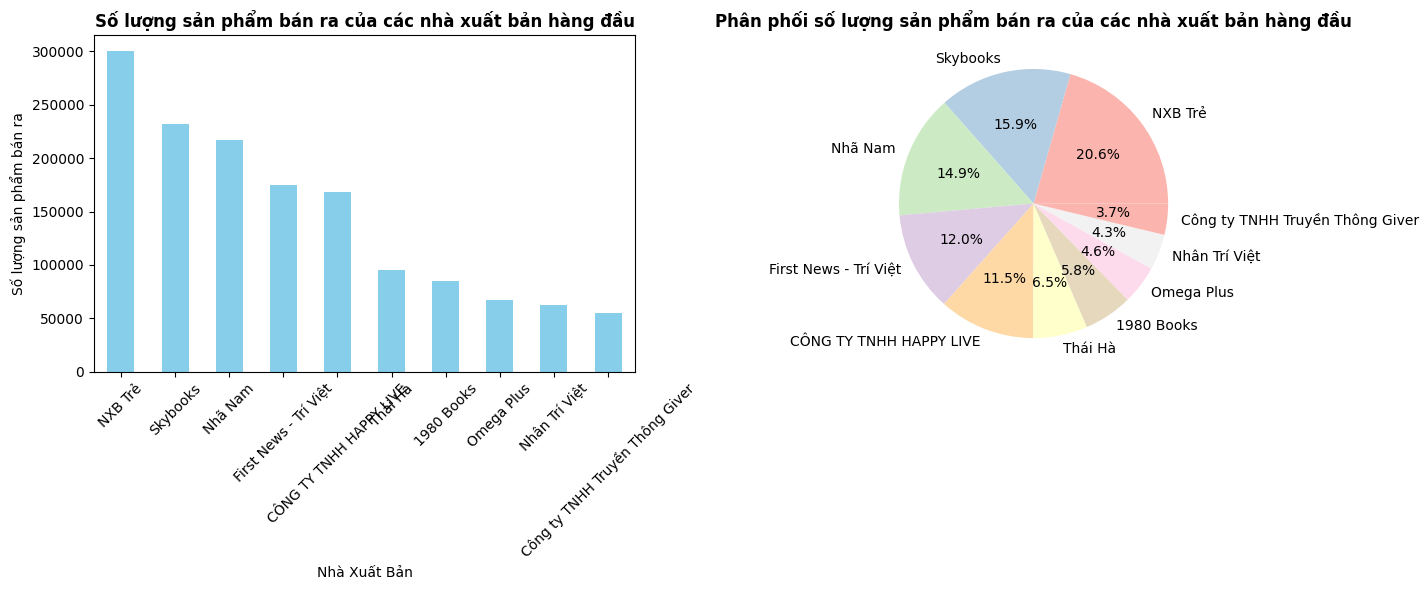

In [ ]:
products_sold_by_publisher = df2.groupby('Publisher')['Quantity Sold'].sum().sort_values(ascending=False)
fig, axes = plt.subplots(1, 2, figsize=(15, 6))


products_sold_by_publisher.head(10).plot(kind='bar', color='skyblue', ax=axes[0])
axes[0].set_title('Số lượng sản phẩm bán ra của các nhà xuất bản hàng đầu', fontweight='bold')
axes[0].set_xlabel('Nhà Xuất Bản')
axes[0].set_ylabel('Số lượng sản phẩm bán ra')
axes[0].tick_params(axis='x', rotation=45)


axes[1].pie(products_sold_by_publisher.head(10), labels=products_sold_by_publisher.head(10).index, autopct='%1.1f%%', colors=sns.color_palette('Pastel1', 10))
axes[1].set_title('Phân phối số lượng sản phẩm bán ra của các nhà xuất bản hàng đầu', fontweight='bold')

plt.tight_layout()
plt.show()

Nhận xét:
*   Đứng đầu về số lượng sản phẩm bán ra lần lượt là 'NXB Trẻ' với 19%, 'Skybooks' với 14.7%, 'Nhã Nam' với 13.7%.
*   Ở Q2, đứng đầu về thị phần là 'Nhã Nam', sau đó là 'NXB Trẻ'. Mặc dù đứng đầu về thị phần nhưng 'Nhã Nam' vẫn thua về số lượng sản phẩm bán ra so với 'NXB Trẻ' và 'Skybooks'
*   'Skybooks' không chiếm thị phần lớn nhưng vấn đứng top 2 về số lượng sản phẩm đã bán.

## 1.2.2. Đánh giá và phân tích các khía cạnh về Cửa hàng phân phối (Store) trên Nhà sách Tiki

#### Q5: Top 10 cửa hàng phân phối nổi bật nhất?

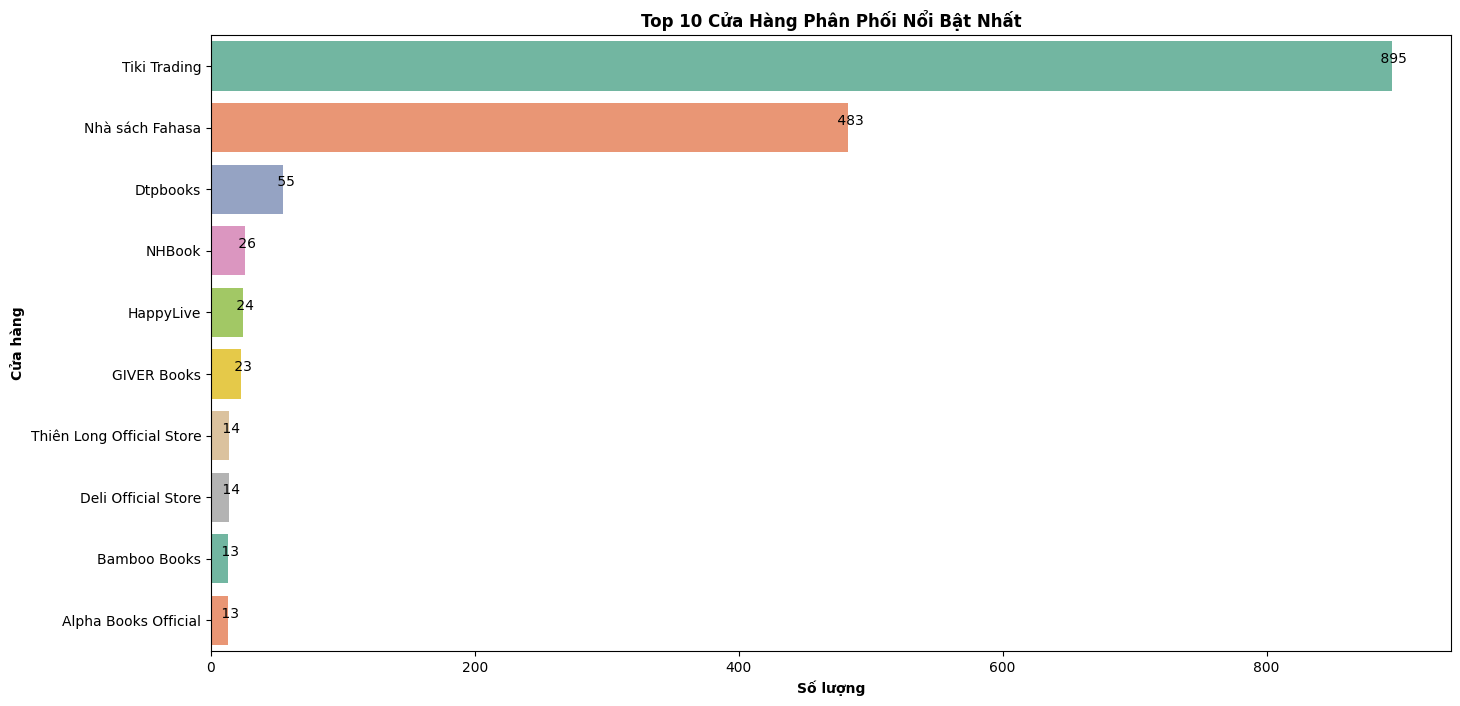

In [ ]:
top_stores = df['Store'].value_counts().head(10).sort_values(ascending=False)
colors = sns.color_palette('Set2', len(top_stores))

plt.figure(figsize=(16, 8))
barplot = sns.barplot(x=top_stores.values, y=top_stores.index, palette=colors)

for i, val in enumerate(top_stores.values):
    barplot.text(val, i, f' {val}', ha='center', va='bottom', color='black')

plt.title('Top 10 Cửa Hàng Phân Phối Nổi Bật Nhất', fontweight='bold')
plt.xlabel('Số lượng', fontweight='bold')
plt.ylabel('Cửa hàng', fontweight='bold')
plt.show()


Nhận xét:
*   Hai cửa hàng chiếm thị phần phân phối sản phẩm lớn nhất trên Nhà sách Tiki là 'Tiki Trading' và 'Nhà sách Fahasa'


### Q6: Top 10 cửa hàng có số lượng sản phẩm đã bán cao nhất? Các cửa hàng có số lượng sản phẩm bán ra cao nhất có phải là các cửa hàng chiếm thị phần phân phối sản phẩm lớn nhất đã phân tích ở Q5 hay không?

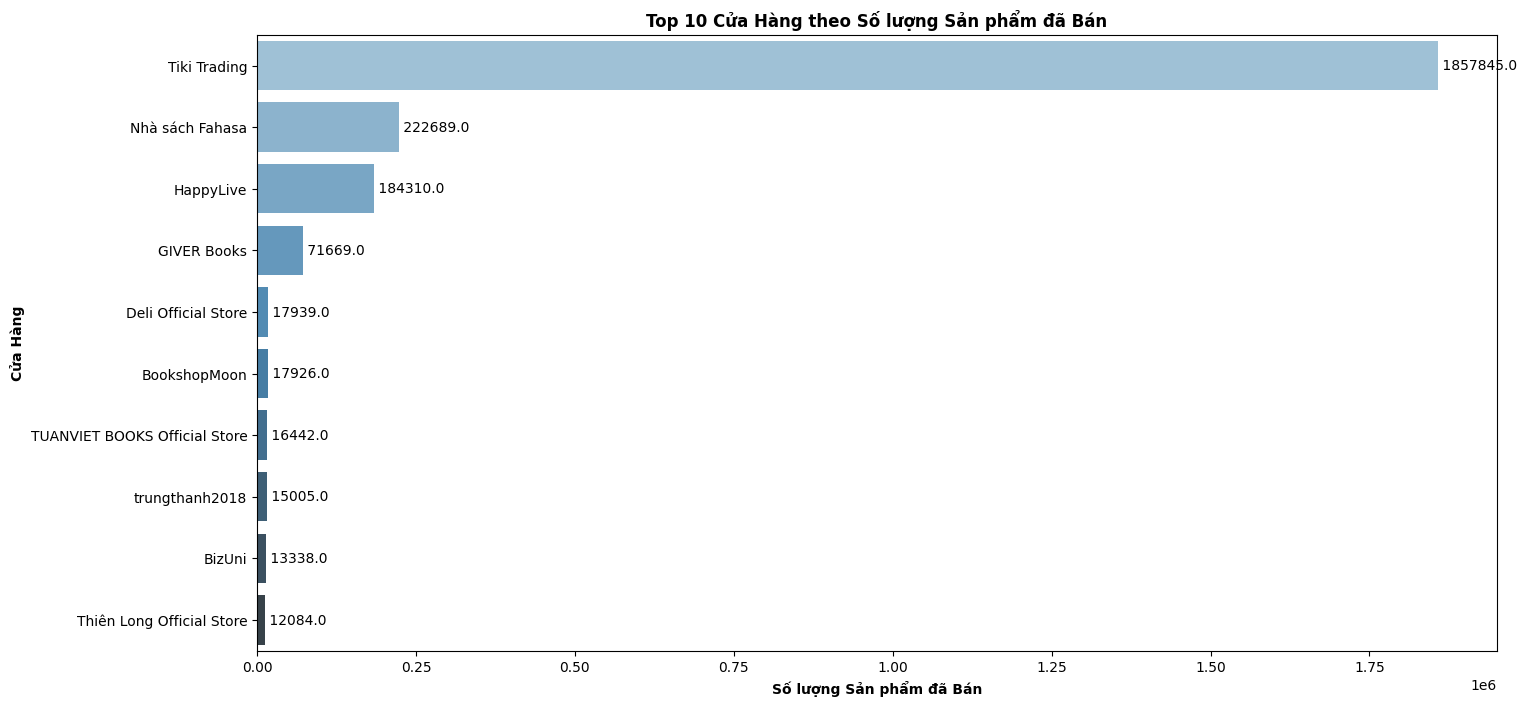

In [ ]:
products_sold_by_store = df2.groupby('Store')['Quantity Sold'].sum().sort_values(ascending=False)

plt.figure(figsize=(16, 8))
barplot = sns.barplot(x=products_sold_by_store.head(10).values, y=products_sold_by_store.head(10).index, palette='Blues_d')

for i, val in enumerate(products_sold_by_store.head(10).values):
    plt.text(val, i, f' {val}', ha='left', va='center', color='black')

plt.title('Top 10 Cửa Hàng theo Số lượng Sản phẩm đã Bán', fontweight='bold')
plt.xlabel('Số lượng Sản phẩm đã Bán', fontweight='bold')
plt.ylabel('Cửa Hàng', fontweight='bold')
plt.show()


Nhận xét:
*   Đứng đầu về số lượng sản phẩm đã bán(Quantity Sold) là hai cửa hàng 'Tiki Trading' và 'Nhà sách Fahasa'.
*   Hai cửa hàng đứng đầu đều là hai cửa hàng nổi bật top đầu trên Nhà sách Tiki đã phân tích ở Q5. Có thể đánh giá tổng quan là cửa hàng chiếm thị phần phân phối sản phẩm lớn thì cũng tỉ lệ thuận với số lượng sản phẩm bán ra.



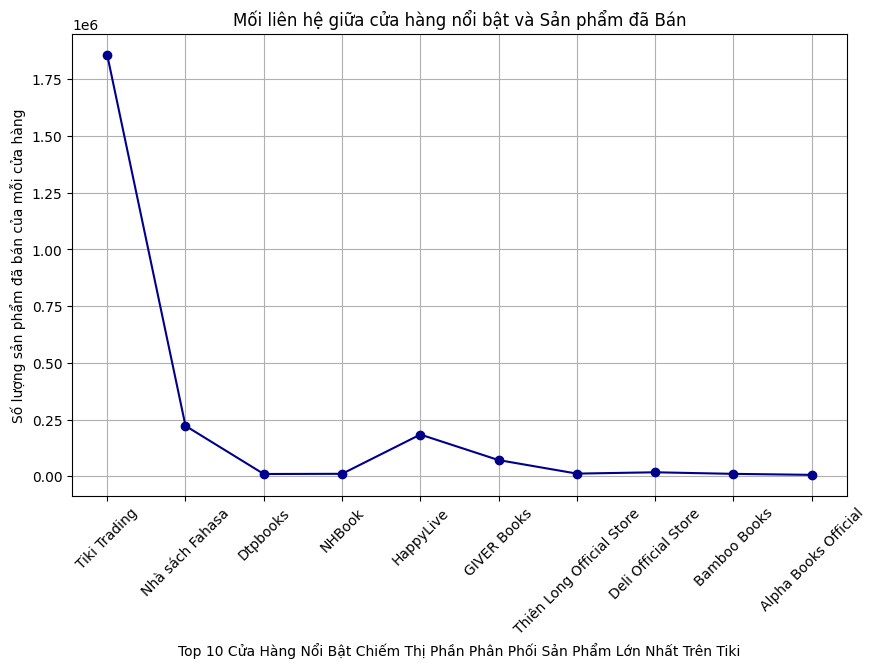

In [ ]:
# Chứng minh cho nhận định 'Có thể đánh giá tổng quan là cửa hàng chiếm thị phần phân phối sản phẩm lớn thì cũng tỉ lệ thuận với số lượng sản phẩm bán ra.'
top_stores = df2['Store'].value_counts().head(10).index.tolist()
products_sold_by_store = df2.groupby('Store')['Quantity Sold'].sum().sort_values(ascending=False)

top_stores_sales = products_sold_by_store.loc[top_stores]

plt.figure(figsize=(10, 6))
plt.plot(top_stores, top_stores_sales, marker='o', linestyle='-', color='darkblue')
plt.xlabel('Top 10 Cửa Hàng Nổi Bật Chiếm Thị Phần Phân Phối Sản Phẩm Lớn Nhất Trên Tiki')
plt.ylabel('Số lượng sản phẩm đã bán của mỗi cửa hàng')
plt.title('Mối liên hệ giữa cửa hàng nổi bật và Sản phẩm đã Bán')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### Q7: Các cửa hàng có doanh số bán hàng cao nhất?

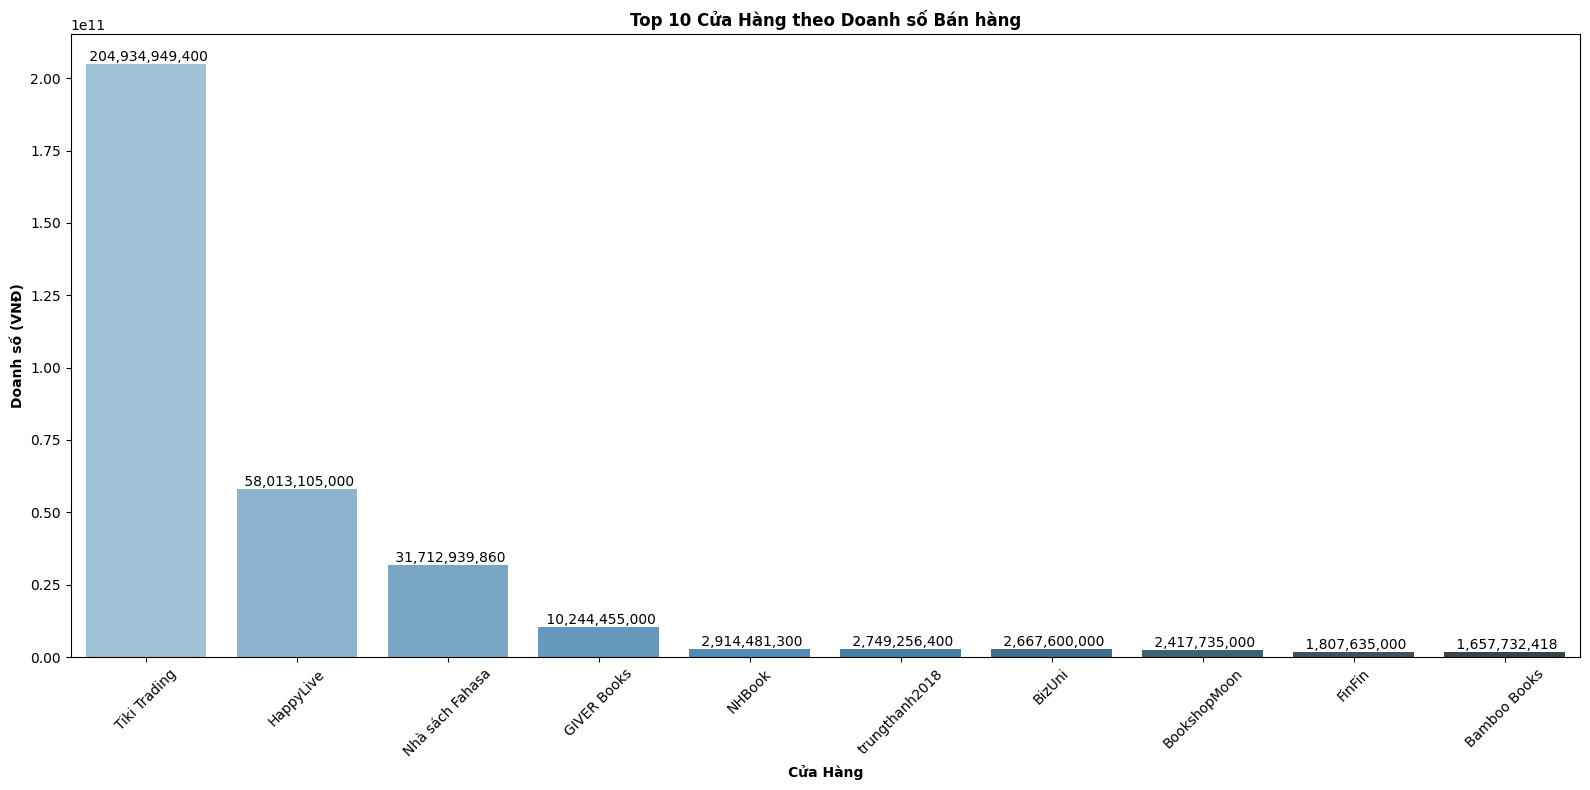

In [ ]:
df2['Total Sales'] = df2['Price'] * df2['Quantity Sold']
total_sales_by_store = df2.groupby('Store')['Total Sales'].sum().sort_values(ascending=False)

plt.figure(figsize=(16, 8))
barplot = sns.barplot(x=total_sales_by_store.head(10).index, y=total_sales_by_store.head(10), palette='Blues_d')

for i, val in enumerate(total_sales_by_store.head(10)):
    barplot.text(i, val, f' {val:,.0f}', ha='center', va='bottom', color='black')

plt.title('Top 10 Cửa Hàng theo Doanh số Bán hàng', fontweight='bold')
plt.xlabel('Cửa Hàng', fontweight='bold')
plt.ylabel('Doanh số (VNĐ)', fontweight='bold')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Nhận xét:
*   Doanh số bán hàng lớn nhất vẫn là Tiki Trading, theo sau là HappyLive và Nhà sách Fahasa.

### Q8: Các cửa hàng có lượt Review cao nhất và rating trung bình của các cửa hàng đó?

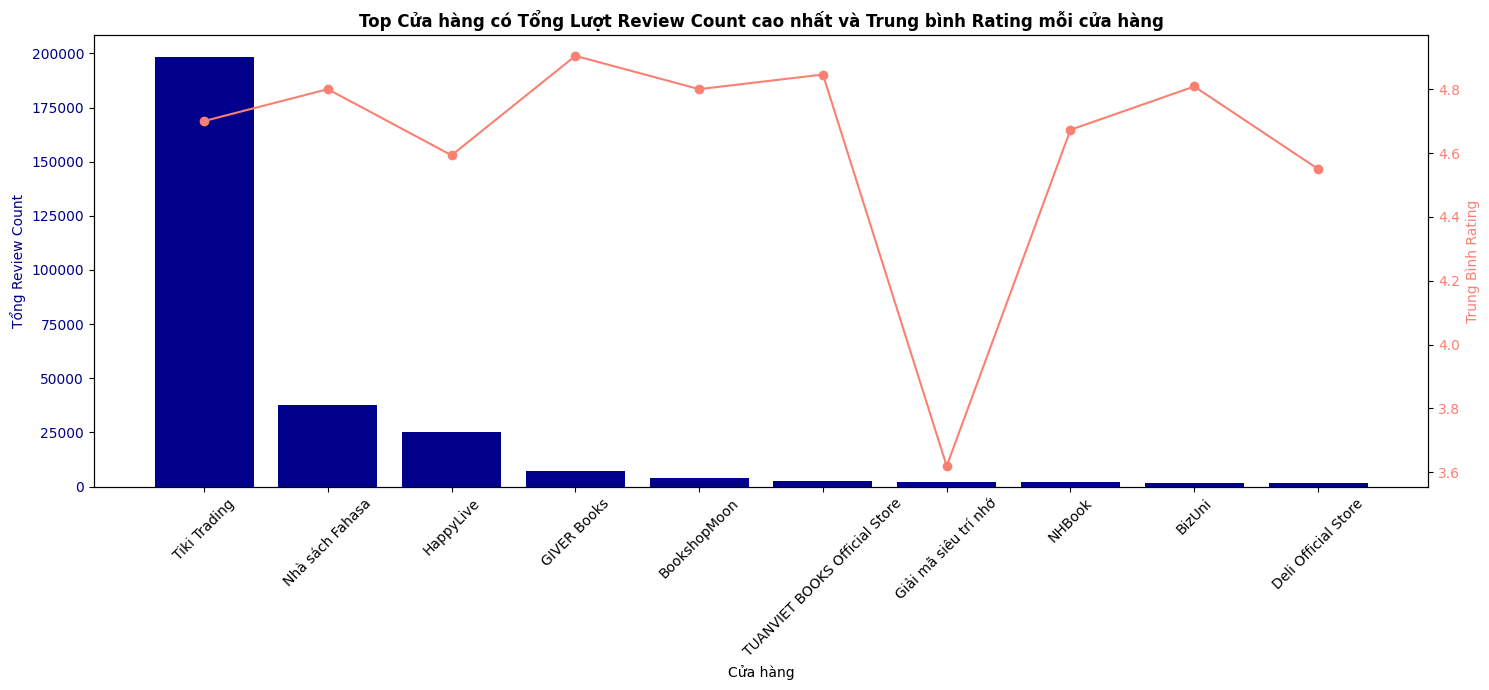

In [ ]:
review_count_by_store = df2.groupby('Store')['Review Count'].sum().sort_values(ascending=False)
top_review_count_stores = review_count_by_store.head(10)

top_review_count_store_data = df2[df2['Store'].isin(top_review_count_stores.index)]

avg_rating_top_review_count_stores = top_review_count_store_data.groupby('Store')['Rating'].mean()

fig, ax1 = plt.subplots(figsize=(15, 7))


# Biểu đồ cột cho tổng Review Count
color = 'darkblue'
ax1.set_xlabel('Cửa hàng')
ax1.set_ylabel('Tổng Review Count', color=color)
ax1.bar(top_review_count_stores.index, top_review_count_stores, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticklabels(top_review_count_stores.index, rotation=45)
ax1.set_title('Top Cửa hàng có Tổng Lượt Review Count cao nhất và Trung bình Rating mỗi cửa hàng', fontweight='bold', color='black')

# Tạo một twin axis cho biểu đồ đường trung bình Rating
ax2 = ax1.twinx()
color = 'salmon'
ax2.set_ylabel('Trung Bình Rating', color=color)
ax2.plot(avg_rating_top_review_count_stores.index, avg_rating_top_review_count_stores, color=color, marker='o')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()


## 1.2.3. Đánh giá và phân tích các khía cạnh về Sản phẩm trên Nhà sách Tiki

### Q9: Những sản phẩm hiện bán chạy nhất trên Nhà sách Tiki?

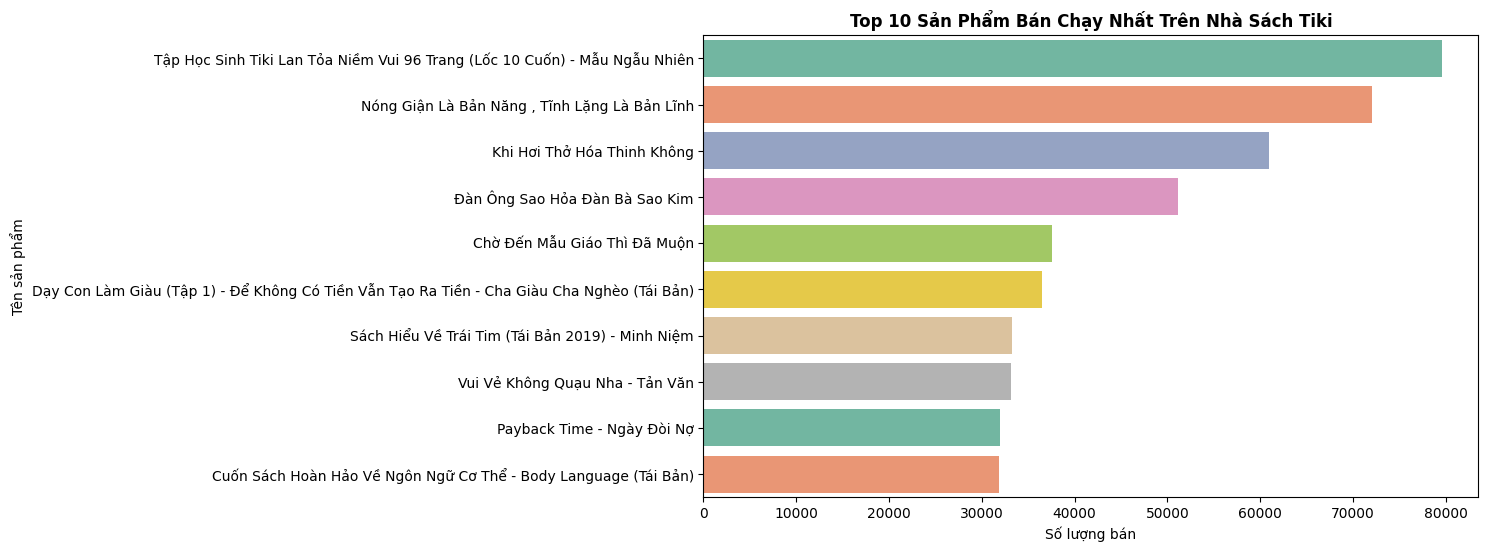

In [ ]:
top_products = df2.groupby('Name')['Quantity Sold'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_products.values, y=top_products.index, palette='Set2')
plt.title('Top 10 Sản Phẩm Bán Chạy Nhất Trên Nhà Sách Tiki', fontweight = 'bold')
plt.xlabel('Số lượng bán')
plt.ylabel('Tên sản phẩm')
plt.show()


Nhận xét:


*   Sách bán chạy nhất đạt ở ngưỡng đỉnh điểm gần 80000.

### Q10: Trên Nhà Sách Tiki, các tác giả nào bán được nhiều sản phẩm nhất?

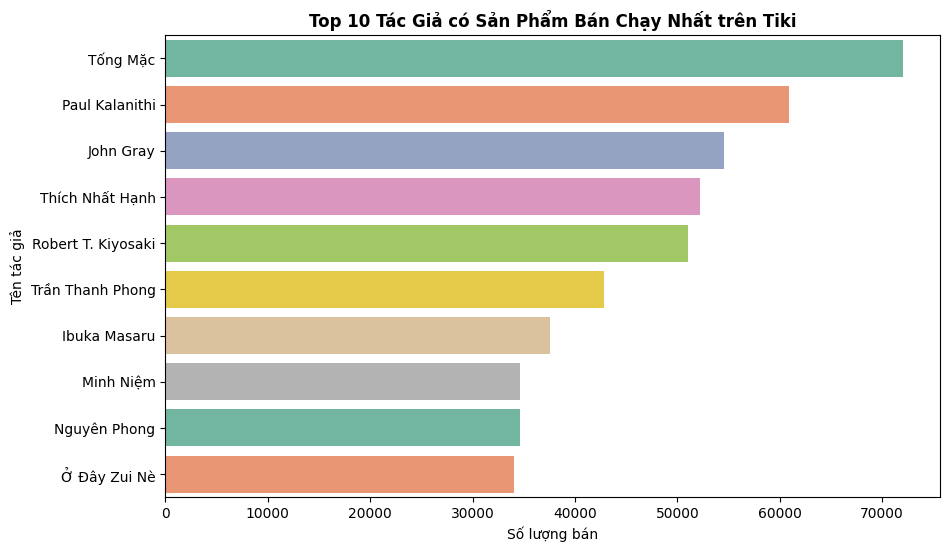

In [ ]:
top_authors = df2.groupby('Author Name')['Quantity Sold'].sum().sort_values(ascending=False)[1:].head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_authors.values, y=top_authors.index, palette='Set2')
plt.title('Top 10 Tác Giả có Sản Phẩm Bán Chạy Nhất trên Tiki',fontweight = 'bold')
plt.xlabel('Số lượng bán')
plt.ylabel('Tên tác giả')
plt.show()


Nhận xét:


*   Tác giả Nguyễn Nhật Ánh có số lượng sách bán vượt trội hơn hẳn các tác giả khác, hơn ít nhất 80000 cuốn. Bán những cuốn sách của tác giả Nguyễn Nhật Ánh có thể giúp tăng số lượng sản phẩm bán ra.

### Q11: Các sản phẩm có nhiều lượt review và rating nhất

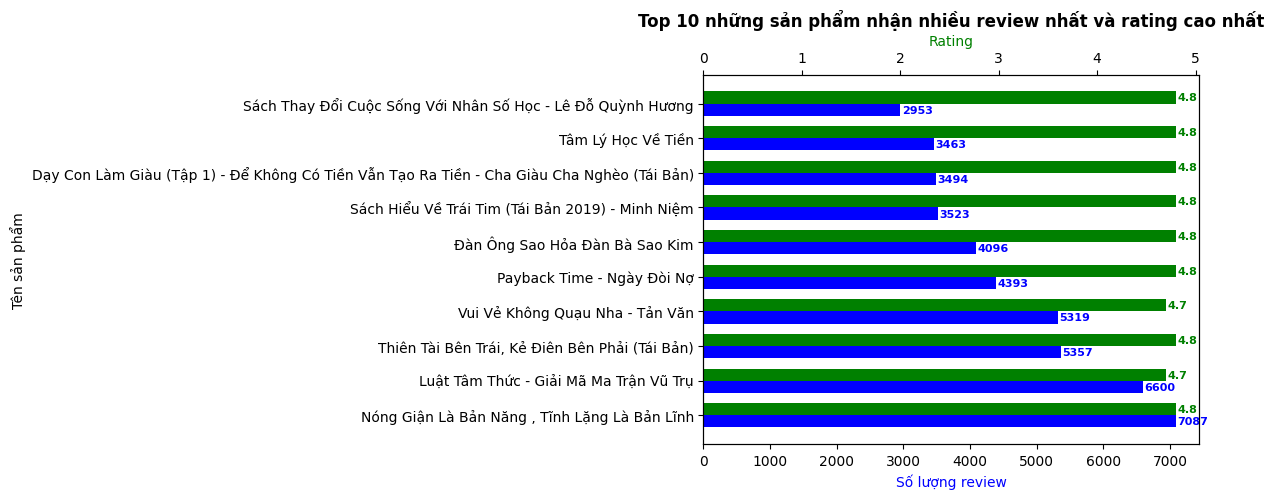

In [ ]:
df_sorted = df2.sort_values(by=['Review Count', 'Rating'], ascending=False)

df_sorted = df_sorted.head(10)
bar_width = 0.35
index = np.arange(len(df_sorted['Name'][:10]))

fig, ax1 = plt.subplots()

bars1 = ax1.barh(index, df_sorted['Review Count'][:10], bar_width, label='Số lượng review', color='blue')
ax2 = ax1.twiny()
bars2 = ax2.barh(index + bar_width, df_sorted['Rating'][:10], bar_width, label='Rating', color='green')

ax1.set_yticks(index + bar_width / 2)
ax1.set_yticklabels(df_sorted['Name'][:10])
ax1.set_ylabel('Tên sản phẩm')
ax1.set_xlabel('Số lượng review', color='blue')
ax2.set_xlabel('Rating', color='green')

for i, v in enumerate(df_sorted['Review Count'][:10]):
    ax1.text(v + 20, i, str(v), color='blue', va='center', fontsize=8, fontweight='bold')

for i, v in enumerate(df_sorted['Rating'][:10]):
    ax2.text(v + 0.02, i + bar_width, str(v), color='green', va='center', fontsize=8, fontweight='bold')

plt.title('Top 10 những sản phẩm nhận nhiều review nhất và rating cao nhất', fontweight='bold')
plt.show()

Nhận xét:


*   'Nóng Giận Là Bản Năng , Tĩnh Lặng Là Bản Lĩnh' nhận được nhiều lượt review nhất và được đánh giá 4.8/5


### Q12: Đánh giá về tỉ lệ Rating cho sản phẩm trên Nhà Sách Tiki?

In [ ]:
!pip install squarify

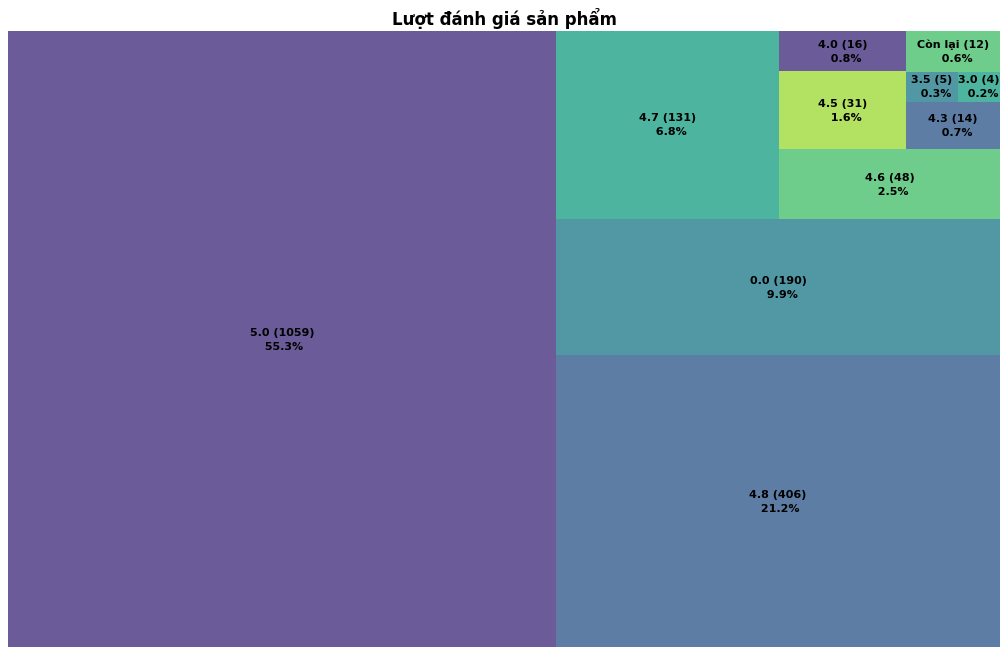

In [ ]:
import squarify
rating=df['Rating'].value_counts().sort_values(ascending=False)
i=0
for ind,val in rating.items():
    rating=rating.rename(index={rating.index[i]: str(ind)})
    i+=1
rating_10=rating[:11]
orthers=rating[10:].values.sum()
rating_10=rating_10.rename(index={rating_10.index[10]: 'Còn lại'})
rating_10[10]=orthers

perc = [str('{:5.1f}%'.format(i/rating_10.values.sum()*100)) for i in rating_10.values]
labels = [el[0] + f' ({el[1]})' "\n" + el[2] for el in zip(rating_10.index, rating_10.values, perc)]
sizes = rating_10.values.tolist()

plt.figure(figsize=(16,10), dpi= 80)
squarify.plot(sizes=sizes, label=labels, color=sns.color_palette('viridis'), alpha=.8, text_kwargs={'fontsize':10,'linespacing':1.5,'fontweight':'bold'})

plt.axis('off')
plt.title('Lượt đánh giá sản phẩm',fontsize=15,weight='bold')
plt.show()

Nhận xét:


*   Qua Biểu đồ cho thấy, nhiều sản phẩm trên Tiki có lượt đánh giá khá tốt, chiếm gần 70% cho rating 5 và 4.8


## 1.2.4. Đánh giá phân tích về Tỉ lệ giảm giá sản phẩm (Discount rate) trên Nhà Sách Tiki

### Q13: Đánh giá theo thời gian về Discount Rate, Price, Quantity Sold

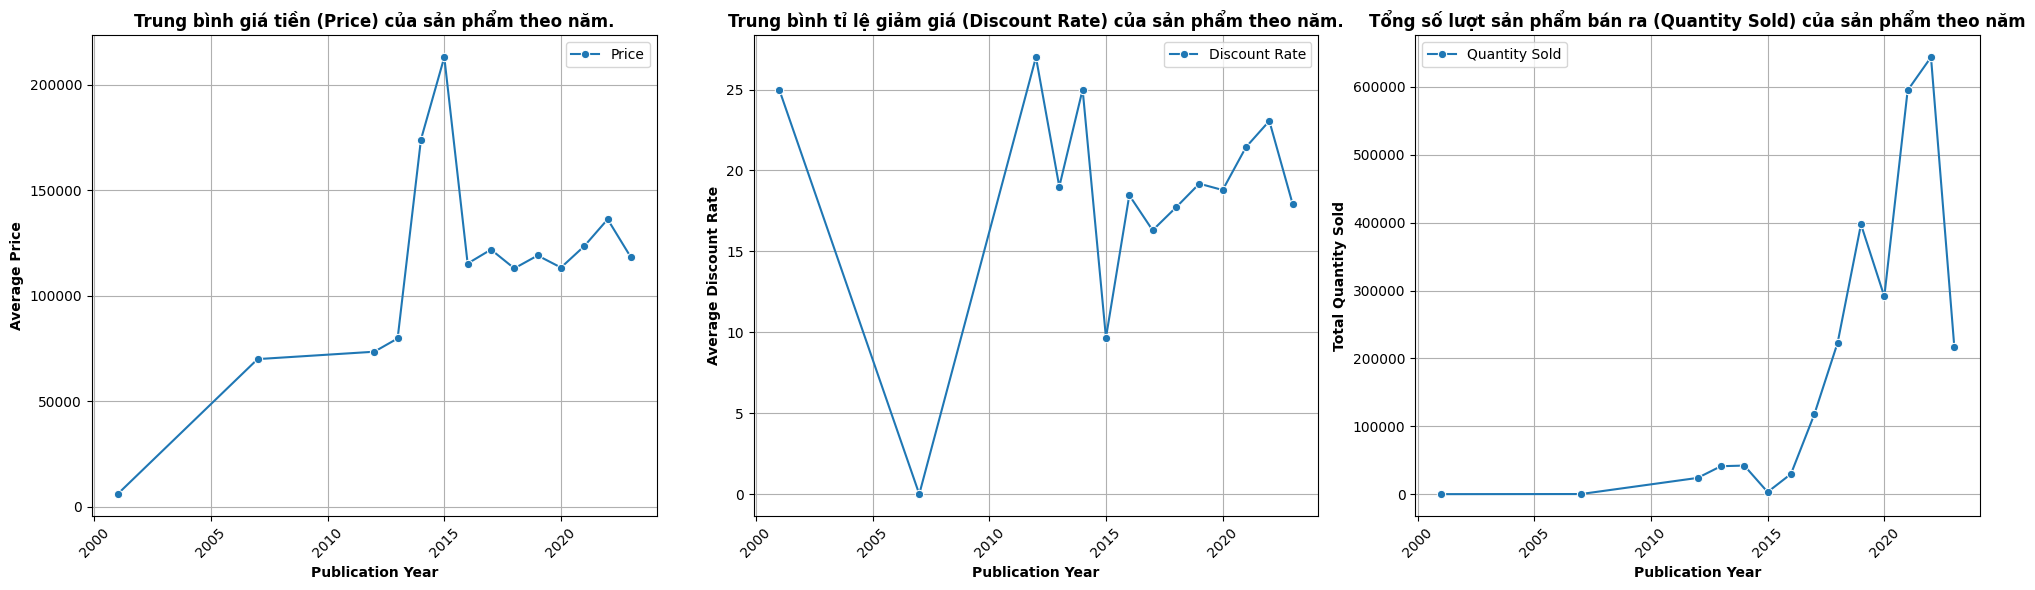

In [ ]:
data_from_2000 = df[df['Publication Year'] >= 2000]
data_list = [
    ('Price', 'Trung bình giá tiền (Price) của sản phẩm theo năm.', 'Average Price'),
    ('Discount Rate', 'Trung bình tỉ lệ giảm giá (Discount Rate) của sản phẩm theo năm.', 'Average Discount Rate'),
    ('Quantity Sold', 'Tổng số lượt sản phẩm bán ra (Quantity Sold) của sản phẩm theo năm', 'Total Quantity Sold')  # Thay đổi tên và tiêu đề
]

plt.figure(figsize=(20, 6))

for i, (column, title, ylabel) in enumerate(data_list, 1):
    plt.subplot(1, 3, i)
    if column == 'Quantity Sold':
        sns.lineplot(x='Publication Year', y=column, data=data_from_2000.groupby('Publication Year')[column].sum().reset_index(), marker='o', label=column)
    else:
        sns.lineplot(x='Publication Year', y=column, data=data_from_2000.groupby('Publication Year')[column].mean().reset_index(), marker='o', label=column)
    plt.title(title, fontweight='bold')
    plt.xlabel('Publication Year', fontweight='bold')
    plt.ylabel(ylabel, fontweight='bold')
    plt.xticks(rotation=45)
    plt.grid(True)

plt.tight_layout()
plt.show()


Nhận xét:


*   Những cuốn sách được xuất bản vào năm 2015 có giá trị tiền cao kỉ lục so với các năm khác và mức giảm giá trung bình ở 10%, chính vì vậy mà số lượt mua vào năm đó lại ở mức thấp nhất là 0.
*   Ở cuốn được xuất bản ở khoảng năm 2022, sách được bán với mức cao nhất đạt đến gần 650000 cuốn với mức giảm giá tầm 23% và giá tiền đạt ở khoảng 100.000
đến 150.000

### Q14: Có sự khác biệt nào về mức độ giảm giá được áp dụng ('Discount Rate') dựa trên các khoảng giảm giá khác nhau không?

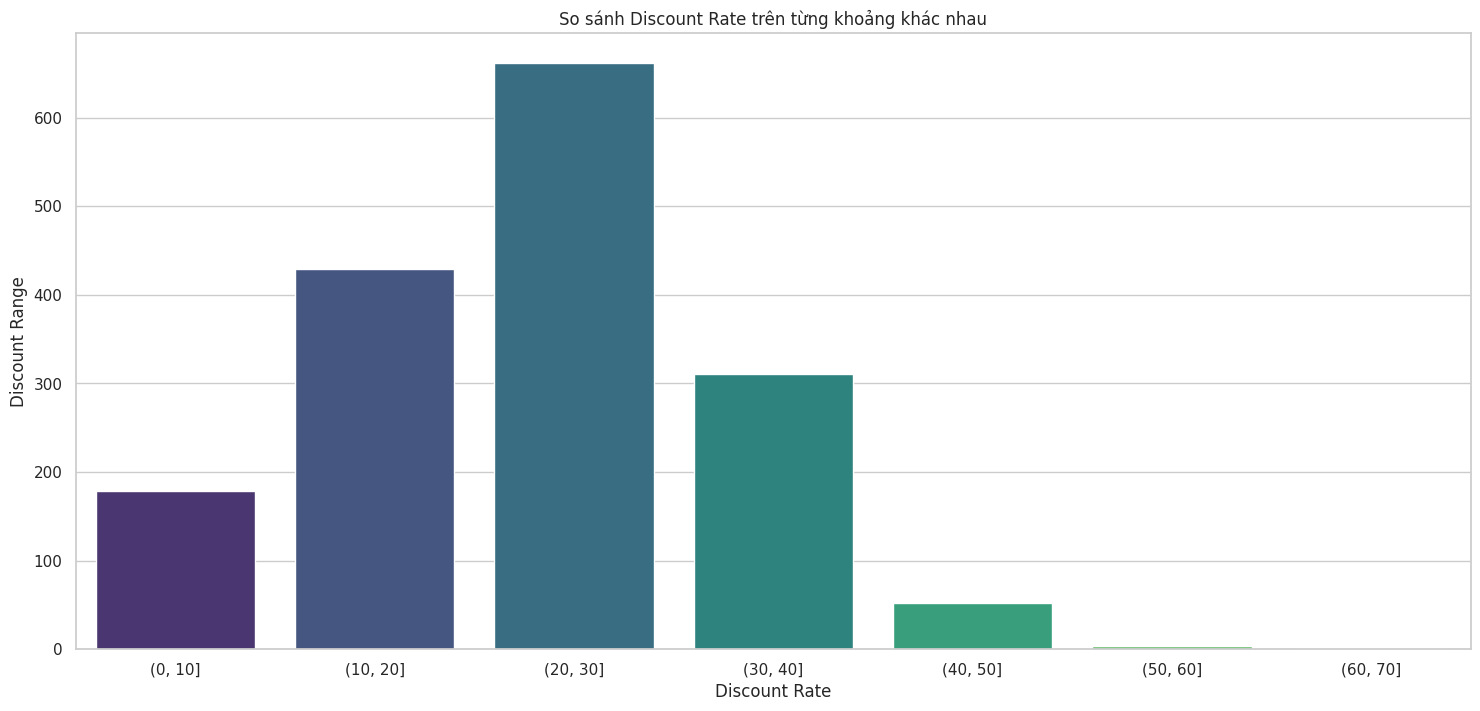

In [ ]:
bins = [0, 10, 20, 30, 40, 50, 60, 70]
df2['Discount Range'] = pd.cut(df2['Discount Rate'], bins=bins)

sns.set(style="whitegrid")

plt.figure(figsize=(18, 8))
sns.barplot(x=df2['Discount Range'].value_counts().index, y=df2['Discount Range'].value_counts().values, palette='viridis')
plt.xlabel('Discount Rate')
plt.ylabel('Discount Range')
plt.title('So sánh Discount Rate trên từng khoảng khác nhau')
plt.show()


Nhận xét:


*   Phân bố giá trị tỉ lệ giảm giá dưới 50% là chiếm số lượng khá lớn, đặc biệt là ở khoảng 20-30% và trên khoảng còn lại rất ít.


### Q15: Top 10 cửa hàng (Store) có trung bình tỉ lệ giảm giá cao nhất?

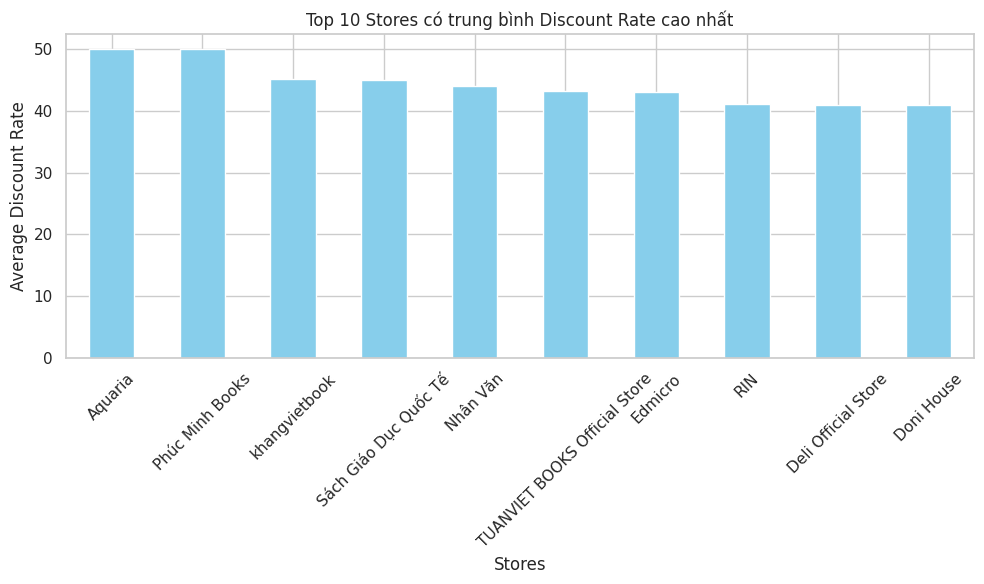

In [ ]:
avg_discount_by_store = df.groupby('Store')['Discount Rate'].mean()

top_10_stores = avg_discount_by_store.nlargest(10)

plt.figure(figsize=(10, 6))
top_10_stores.plot(kind='bar', color='skyblue')
plt.xlabel('Stores')
plt.ylabel('Average Discount Rate')
plt.title('Top 10 Stores có trung bình Discount Rate cao nhất')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Nhận xét:


*   Tỉ lệ giảm giá trên 10 cửa hàng có tỉ lệ cao nhất khá đồng đều, không chêch lệch nhau quá 10%

### Q16: Top 10 sản phẩm hiện giảm giá cao nhất trên Nhà sách Tiki?

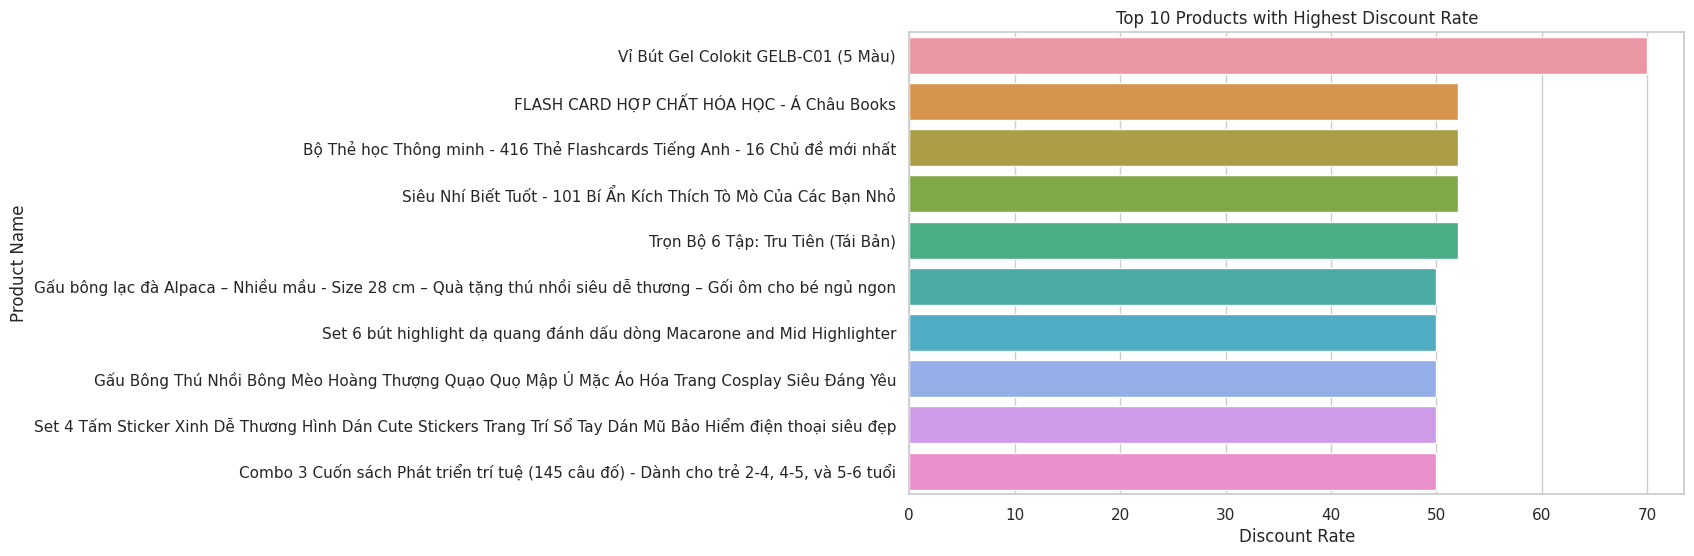

In [ ]:
top_10_products = df.sort_values(by='Discount Rate', ascending=False).head(10)

sns.set_palette("viridis")

plt.figure(figsize=(10, 6))
sns.barplot(x='Discount Rate', y='Name', data=top_10_products)
plt.xlabel('Discount Rate')
plt.ylabel('Product Name')
plt.title('Top 10 Products with Highest Discount Rate')
plt.show()

Nhận xét:


*   Trong 10 sản phẩm có tỉ lệ giảm giá cao nhất, 'Vỉ Bút Gel Colokit GELB-C01(5 Màu) có tỉ lệ giảm cao nhất và vượt trội hơn các sản phẩm còn lại khoảng 20%

### Q17: Lấy ra các thuộc tính có độ tương quan cao với biến 'Discount Rate'

In [ ]:
def find_correlated_features_numeric(df, target):
    df_num_corr = df.corr()[target]
    correlated_features = df_num_corr[abs(df_num_corr) > 0.1].sort_values(ascending=False)
    return list(correlated_features.index)

num_correlated_list = find_correlated_features_numeric(df1, 'Discount Rate')
feature_selected = num_correlated_list[1:]
feature_selected

['Discount',
 'Store',
 'Rating',
 'Original Price',
 'Categories',
 'Quantity Sold',
 'Review Count',
 'Author Name']

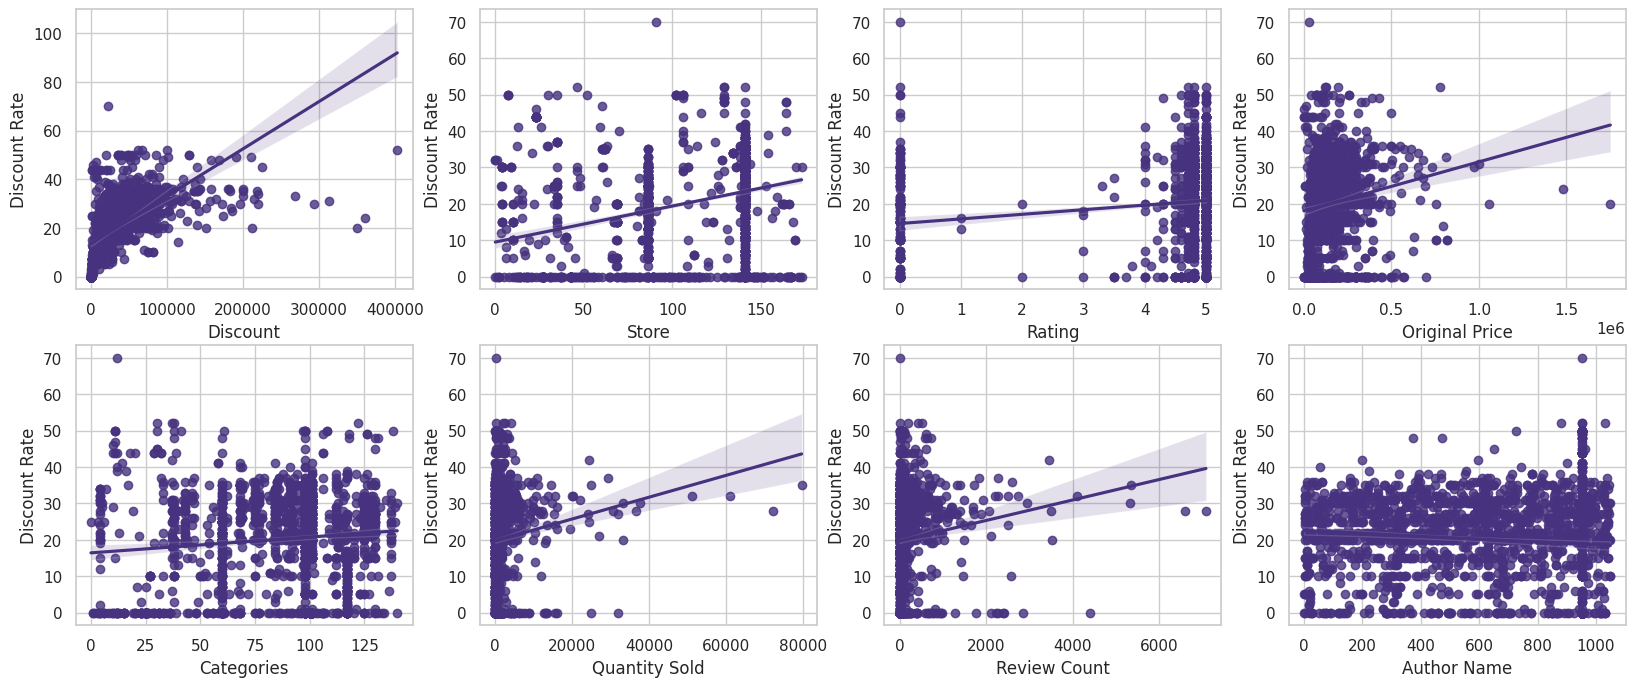

In [ ]:
def show_regression(feature_selected, target, df):
  fig, ax = plt.subplots(round(len(feature_selected) / 4), 4, figsize = (20, 8))

  for i, ax in enumerate(fig.axes):
      if i < len(feature_selected):
          sns.regplot(x=feature_selected[i], y=target, data=df, ax=ax)

show_regression(feature_selected, 'Discount Rate', df1[feature_selected + ['Discount Rate']])

Nhận xét:


*   Trong tất cả các biến tương quan với 'Discount Rate', Biến 'Discount' tương quan nhất và hầu hết các biến đều tương quan thuận.

## 1.2.5 Phân tích về giá sản phẩm

### Q18: Gía trị Price nhỏ nhất và lớn nhất là bao nhiêu?

In [ ]:
print("Gía trị Price nhỏ nhất là: ", df1.Price.min())
print("Gía trị Price lớn nhất là: ", df1.Price.max())

Gía trị Price nhỏ nhất là:  1900
Gía trị Price lớn nhất là:  1400000


Nhận xét: Có mức giá 1900 là vì cửa hàng bán các phụ kiện như: kẹp, bìa bao

### Q19: Độc giả mua sách với mức giá như thế nào?

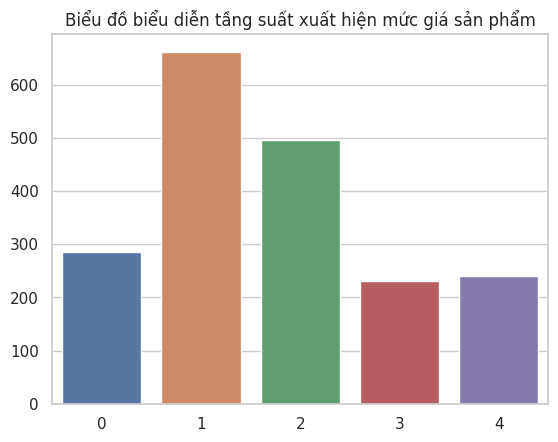

In [ ]:
sns.barplot(x=df1['Range Price'].value_counts().index, y=df1['Range Price'].value_counts().values)
plt.title('Biểu đồ biểu diễn tầng suất xuất hiện mức giá sản phẩm')
plt.show()

Nhận xét:


*   Mức giá tập trung ở mức 2 và 3


# III. Model

In [ ]:
pip install hvplot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 14.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import hvplot.pandas
import random
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Lasso

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from scipy.stats import pointbiserialr
from sklearn.preprocessing import LabelEncoder
import scipy.stats as stats

In [ ]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
def convert_categorical_var(df):
  le = LabelEncoder()

  categorical_var = ['Store', 'Type', 'Author Name','Publisher',
       'Translators', 'Categories', 'Range Price']

  for col in categorical_var:
    df[col] = le.fit_transform(df[col])
  return df


df1 = convert_categorical_var(df1)
df1.head()

Name  \
0  Kế Toán Vỉa Hè - Thực Hành Báo Cáo Tài Chính Căn Bản Từ Quầy Bán Nước Chanh                                                                              
1  Mùa hè không tên (Nguyễn Nhật Ánh) - Tặng kèm Bookmark, Tranh màu, Sổ note cho cả 2 phiên bản - Tặng thêm ngẫu nhiên 1 trong 2 Lót ly cho Bản bìa cứng   
2  Không Diệt Không Sinh Đừng Sợ Hãi (TB5)                                                                                                                  
3  Cây Cam Ngọt Của Tôi                                                                                                                                     
4  Nghệ Thuật Tư Duy Chiến Lược                                                                                                                             

                                                                                                               Link Product  \
0  https://tiki.vn/ke-toan-via-he-thuc-hanh-bao-cao-tai-chinh-can-ban-tu-quay-ban-nuoc-chanh-p262977989.html?spid=262977990   
1  https://tiki.vn/mua-he-khong-ten-nguyen-nhat-anh-p271916321.html?spid=271916323                                            
2  https://tiki.vn/khong-diet-khong-sinh-dung-so-hai-tb5-p187827003.html?spid=187827005                                       
3  https://tiki.vn/cay-cam-ngot-cua-toi-p74021317.html?spid=74677933                                                          
4  https://tiki.vn/nghe-thuat-tu-duy-chien-luoc-p12138656.html?spid=20479537                                                  

   Store  Type  Author Name  \
0  35     1     953           
1  141    0     631           
2  141    1     867           
3  86     1     428           
4  86     1     73            

                                                                                                                                                                                             Short Description  \
0  BIẾN KẾ TOÁN KHÔ KHAN TRỞ THÀNH TRÒ CHƠI CON TRẺ, DỄ HIỂU VÀ DỄ ÁP DỤNGĐã bao lần bạn cầm trên tay bảng báo cáo tài chính doanh nghiệp của mình, nhưng chẳng thể nào hiểu nổi? Kế toán và tài chính là...     
1  “Mùa hè không tên” là truyện dài mới nhất của nhà văn Nguyễn Nhật Ánh, với những câu chuyện tuổi thơ với vô số trò tinh nghịch, những thoáng thinh thích hồi hộp cùng vô vàn kỷ niệm. Để rồi khi những t...   
2  Nhiều người trong chúng ta tin rằng cuộc đời của ta bắt đầu từ lúc chào đời và kết thúc khi ta chết. Chúng ta tin rằng chúng ta tới từ cái Không, nên khi chết chúng ta cũng không còn lại gì hết. Và ch...   
3  “Vị chua chát của cái nghèo hòa trộn với vị ngọt ngào khi khám phá ra những điều khiến cuộc đời này đáng số một tác phẩm kinh điển của Brazil.”- Booklist“Một cách nhìn cuộc sống gần như hoàn chỉnh t...     
4  Có phải những người chiến thắng các chương trình truyền hình thực tế được trời phú cho trí thông minh và kỹ năng hơn người?Có phải các nhà đầu tư vĩ đại có thể nhìn thấy những điều mà hầu hết mọi ngư...    

   Publisher  Translators  Categories  Width  Length  Height  Product ID   Price  Original Price  \
0  63         516          99          13.0   20.0    0.0     262977989   169000  199000           
1  118        553          120         13.0   20.0    0.0     271916321   109000  130000           
2  164        553          101         14.0   20.5    0.0     187827003   76000   110000           
3  148        271          98          14.0   20.5    0.0     74021317    75600   108000           
4  5          172          98          16.0   24.0    0.0     12138656    174500  239000           

   Discount  Discount Rate  Rating  Review Count  Quantity Sold  Number of page  Range Price  \
0  30000     15             5.0     111           5990.0         268.0           3             
1  21000     16             4.8     141           1715.0         292.0           2             
2  34000     31             5.0     1481          21867.0        224.0           1             
3  32400  

In [ ]:
def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    rmsle = np.sqrt(np.mean(np.log1p(np.square(np.log1p(y_pred) - np.log1p(y_true)))))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    return mae, mse, rmse, r2, rmsle, mape

In [ ]:
def print_score(eval):
    print(f"    MAE: {eval[0]:.2f}")
    print(f"    MSE: {eval[1]:.2f}")
    print(f"    RMSE: {eval[2]:.2f}")
    print(f"    R-squared: {eval[3]:.4f}")
    print(f"    RMSLE: {eval[4]:.2f}")
    print(f"    MAPE: {eval[5]:.2f}%")

## 1.Linear Regression

In [ ]:
## Chọn những biến có độ tương quan cao với biến mục tiêu
X=df1[['Discount', 'Store', 'Rating', 'Original Price', 'Categories', 'Quantity Sold', 'Review Count', 'Author Name']]
y=df1['Discount Rate']

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)


In [ ]:
lr=LinearRegression()

lr.fit(x_train,y_train)
lr_pred_train=lr.predict(x_train)
lr_pred=lr.predict(x_test)

lr_eval = evaluate_model(y_test, lr_pred)
print("Linear Regression:\n")
print('Đánh giá trên tập train:')
print_score(evaluate_model(y_train, lr_pred_train))
print('====================================\n')
print('Đánh giá trên tập test:')
print_score(lr_eval)

Linear Regression:

Đánh giá trên tập train:
    MAE: 5.49
    MSE: 60.32
    RMSE: 7.77
    R-squared: 0.5916
    RMSLE: 0.56
    MAPE: inf%

Đánh giá trên tập test:
    MAE: 4.88
    MSE: 46.84
    RMSE: 6.84
    R-squared: 0.6586
    RMSLE: 0.52
    MAPE: inf%


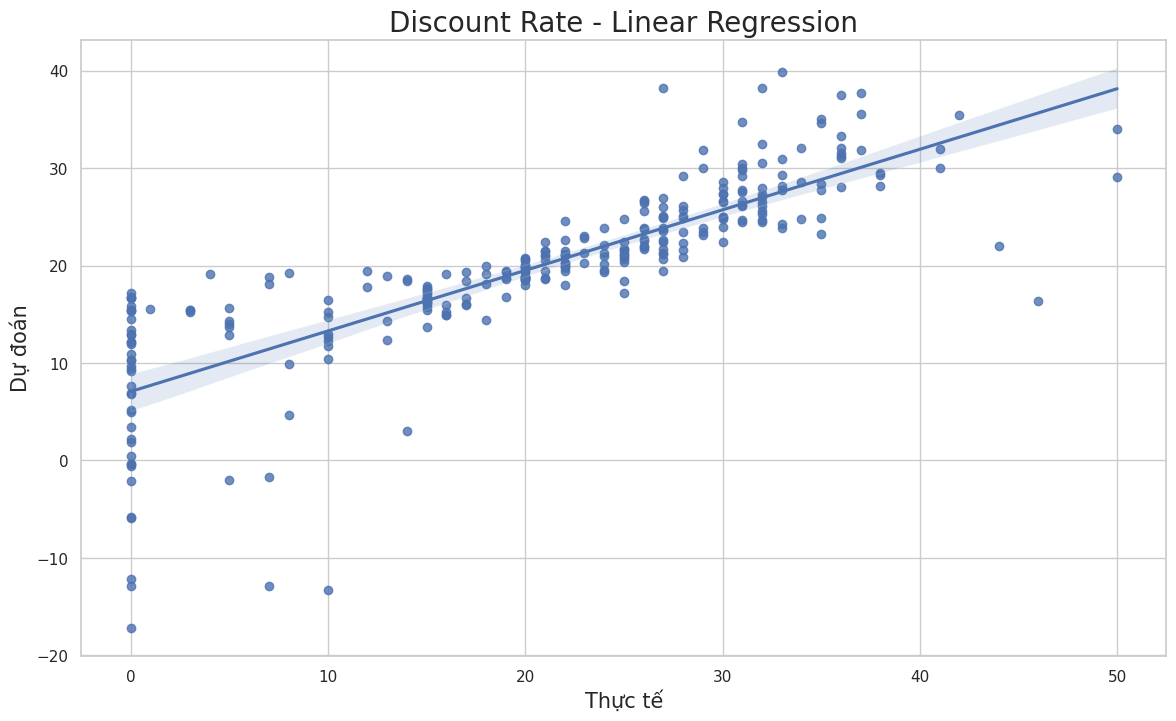

In [ ]:
out=pd.DataFrame({'Thực tế':y_test,'Dự đoán':lr_pred})
result=df1.merge(out,left_index=True,right_index=True)

plt.figure(figsize=(14,8))
sns.regplot(x='Thực tế',y='Dự đoán',data=result)
plt.title('Discount Rate - Linear Regression',fontsize=20)
plt.xlabel('Thực tế',fontsize=15)
plt.ylabel('Dự đoán',fontsize=15)
plt.show()

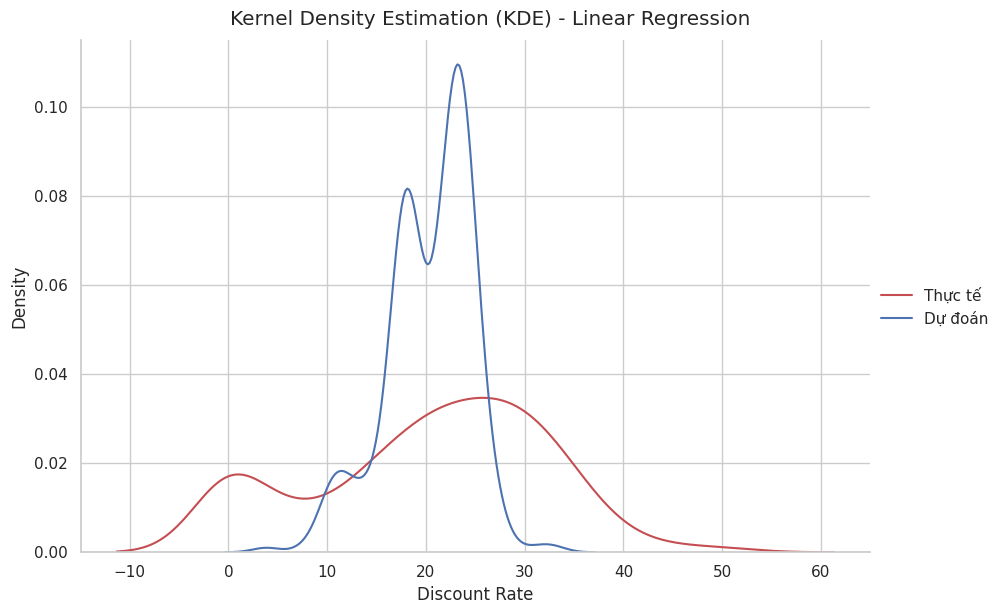

In [ ]:
g = sns.FacetGrid(pd.DataFrame({'Thực tế':y_test, 'Dự đoán': lr_pred}), height=6, aspect=1.5)

g.map(sns.kdeplot, 'Thực tế', color='r', label='Thực tế')
g.map(sns.kdeplot, 'Dự đoán', color='b', label='Dự đoán')
g.set_axis_labels('Discount Rate', 'Density')
g.fig.suptitle('Kernel Density Estimation (KDE) - Linear Regression', y=1.02)

g.add_legend()
plt.show()

## 2.Rigde Regression

In [ ]:
X=df1[['Discount', 'Store', 'Rating', 'Original Price', 'Categories', 'Quantity Sold', 'Review Count', 'Author Name']]
y=df1['Discount Rate']

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Tìm alpha tối ưu
alphas = np.logspace(-6, 6, 13)
ridge = Ridge()

param_grid = {'alpha': alphas}

grid_search = GridSearchCV(ridge, param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(x_train, y_train)

# Hiển thị giá trị alpha tốt nhất và kết quả
best_alpha = grid_search.best_params_['alpha']
best_score = grid_search.best_score_

print('Hệ số alpha tối ưu: ',best_alpha)
print('Kết quả tốt nhất: ',best_score)

rr_pred_train = grid_search.predict(x_train)
rr_pred = grid_search.predict(x_test)

Hệ số alpha tối ưu:  1000.0
Kết quả tốt nhất:  -62.09990779784236


In [ ]:
rr_eval = evaluate_model(y_test, rr_pred)
print("Ridge Regression:\n")
print('Đánh giá trên tập train:')
print_score(evaluate_model(y_train, rr_pred_train))
print('====================================\n')
print('Đánh giá trên tập test:')
print_score(rr_eval)


Ridge Regression:

Đánh giá trên tập train:
    MAE: 5.49
    MSE: 60.34
    RMSE: 7.77
    R-squared: 0.5915
    RMSLE: 0.56
    MAPE: inf%

Đánh giá trên tập test:
    MAE: 4.89
    MSE: 47.01
    RMSE: 6.86
    R-squared: 0.6573
    RMSLE: 0.52
    MAPE: inf%


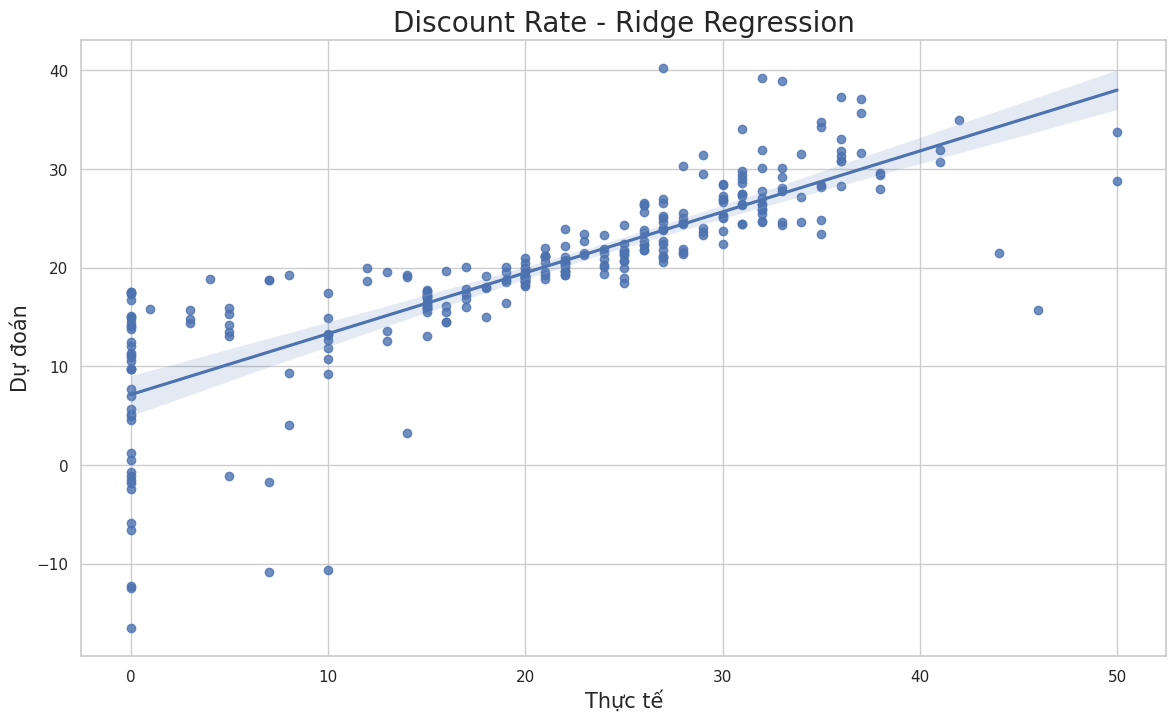

In [ ]:
out=pd.DataFrame({'Thực tế':y_test,'Dự đoán':rr_pred})
result=df1.merge(out,left_index=True,right_index=True)

plt.figure(figsize=(14,8))
sns.regplot(x='Thực tế',y='Dự đoán',data=result)
plt.title('Discount Rate - Ridge Regression',fontsize=20)
plt.xlabel('Thực tế',fontsize=15)
plt.ylabel('Dự đoán',fontsize=15)
plt.show()

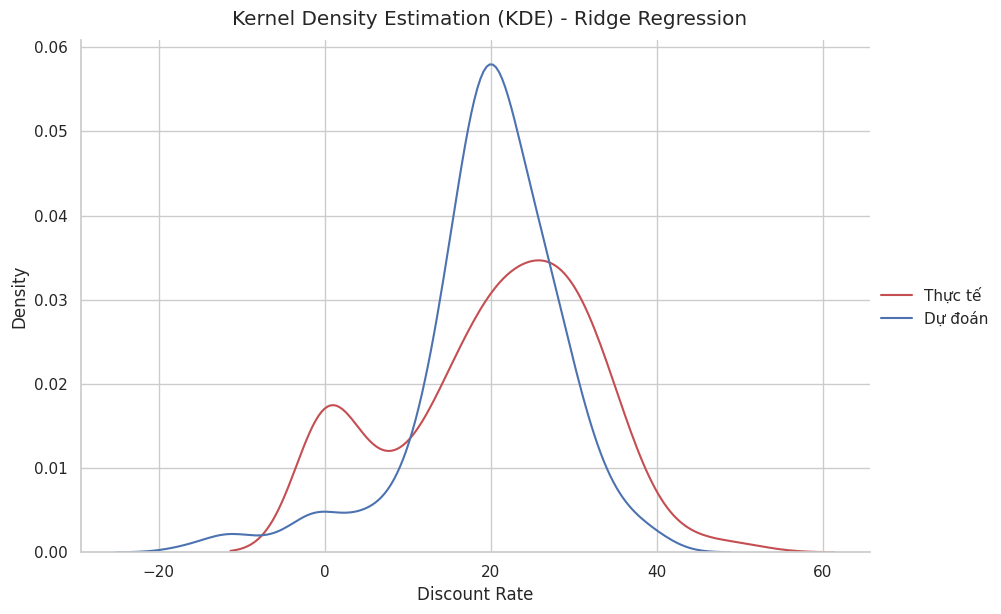

In [ ]:
pd.DataFrame({'Error values': (y_test - rr_pred)}).hvplot.kde()
g = sns.FacetGrid(pd.DataFrame({'Giá trị thực':y_test, 'Dự đoán': rr_pred}), height=6, aspect=1.5)

g.map(sns.kdeplot, 'Giá trị thực', color='r', label='Thực tế')
g.map(sns.kdeplot, 'Dự đoán', color='b', label='Dự đoán')
g.set_axis_labels('Discount Rate', 'Density')
g.fig.suptitle('Kernel Density Estimation (KDE) - Ridge Regression', y=1.02)

g.add_legend()
plt.show()

## 3.Lasso Regression

In [ ]:
# Tìm alpha tối ưu
alphas = np.logspace(-3, 3, 7)
lasso = Lasso()

# Thiết lập siêu tham số cần kiểm tra
param_grid = {'alpha': alphas}

# Sử dụng GridSearchCV để tìm giá trị alpha tốt nhất
grid_search = GridSearchCV(lasso, param_grid, scoring='r2', cv=5)
grid_search.fit(x_train, y_train)

# Hiển thị giá trị alpha tốt nhất và kết quả
best_alpha = grid_search.best_params_['alpha']
best_score = grid_search.best_score_

print('Hệ số alpha tối ưu: ',best_alpha)
print('Kết quả tốt nhất: ',best_score)
lar_pred_train=grid_search.predict(x_train)
lar_pred=grid_search.predict(x_test)

Hệ số alpha tối ưu:  0.001
Kết quả tốt nhất:  0.579122532839765


In [ ]:
lar_eval = evaluate_model(y_test, lar_pred)
print("Lasso Regression:\n")
print('Đánh giá trên tập train:')
print_score(evaluate_model(y_train, lar_pred_train))
print('====================================\n')
print('Đánh giá trên tập test:')
print_score(lar_eval)

Lasso Regression:

Đánh giá trên tập train:
    MAE: 5.49
    MSE: 60.32
    RMSE: 7.77
    R-squared: 0.5916
    RMSLE: 0.56
    MAPE: inf%

Đánh giá trên tập test:
    MAE: 4.88
    MSE: 46.84
    RMSE: 6.84
    R-squared: 0.6585
    RMSLE: 0.52
    MAPE: inf%


In [ ]:
# Hiển thị các hệ số của các biến
lasso=Lasso(alpha=10)
lasso.fit(x_train,y_train)
feature_importance = pd.DataFrame({'Thuộc tính': X.columns, 'Hệ số': lasso.coef_})
print(feature_importance)
rfe = RFE(lasso, n_features_to_select=5)
fit_ = rfe.fit(x_train, y_train)
print("Top 5 hệ số ảnh hưởng lớn nhất:", X.columns[fit_.support_])

       Thuộc tính     Hệ số
0  Discount        0.000366
1  Store           0.019551
2  Rating          0.000000
3  Original Price -0.000071
4  Categories      0.011082
5  Quantity Sold   0.000124
6  Review Count    0.001250
7  Author Name    -0.001132
Top 5 hệ số ảnh hưởng lớn nhất: Index(['Store', 'Categories', 'Quantity Sold', 'Review Count', 'Author Name'], dtype='object')


## 4.Polynomial Regression

In [ ]:
# Định nghĩa mô hình Polynomial Regression dưới dạng pipeline
model = make_pipeline(PolynomialFeatures(), LinearRegression())

# Thiết lập các tham số cần tìm kiếm
param_grid = {'polynomialfeatures__degree': np.arange(1, 7)}

# Sử dụng GridSearchCV để tìm độ cao tối ưu
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(x_train, y_train)

# In độ cao tối ưu và điểm số tương ứng
best_degree = grid_search.best_params_['polynomialfeatures__degree']
best_score = -grid_search.best_score_
print(f'Best Degree: {best_degree}')
print(f'Best Mean Squared Error on Training Set: {best_score}')
poly_train=grid_search.predict(x_train)
poly_pred=grid_search.predict(x_test)

Best Degree: 1
Best Mean Squared Error on Training Set: 62.12522577036617


In [ ]:
poly_eval = evaluate_model(y_test, poly_pred)
print("Polynomial Linear Regression:\n")
print('Đánh giá trên tập train:')
print_score(evaluate_model(y_train, poly_train))
print('====================================\n')
print('Đánh giá trên tập test:')
print_score(poly_eval)

Polynomial Linear Regression:

Đánh giá trên tập train:
    MAE: 5.49
    MSE: 60.32
    RMSE: 7.77
    R-squared: 0.5916
    RMSLE: 0.56
    MAPE: inf%

Đánh giá trên tập test:
    MAE: 4.88
    MSE: 46.84
    RMSE: 6.84
    R-squared: 0.6586
    RMSLE: 0.52
    MAPE: inf%


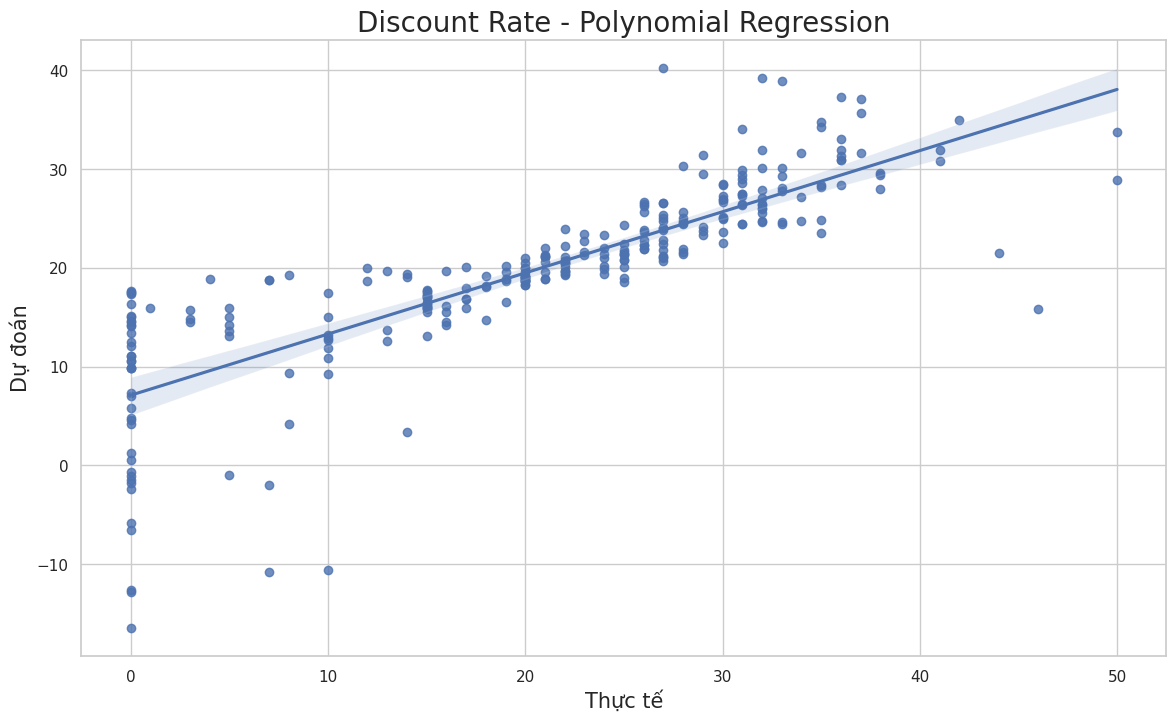

In [ ]:
out=pd.DataFrame({'Thực tế':y_test,'Dự đoán':poly_pred})
result=df1.merge(out,left_index=True,right_index=True)

plt.figure(figsize=(14,8))
sns.regplot(x='Thực tế',y='Dự đoán',data=result)
plt.title('Discount Rate - Polynomial Regression',fontsize=20)
plt.xlabel('Thực tế',fontsize=15)
plt.ylabel('Dự đoán',fontsize=15)
plt.show()

In [ ]:
pd.DataFrame({'Error values': (y_test - poly_pred)}).hvplot.kde()

/usr/local/lib/python3.10/dist-packages/holoviews/core/util.py:1585: PanelDeprecationWarning: 'param_value_if_widget' is deprecated and will be removed in version 1.4, use 'transform_reference' instead.
  value = param_value_if_widget(value)


:Distribution   [Error values]   (Density)

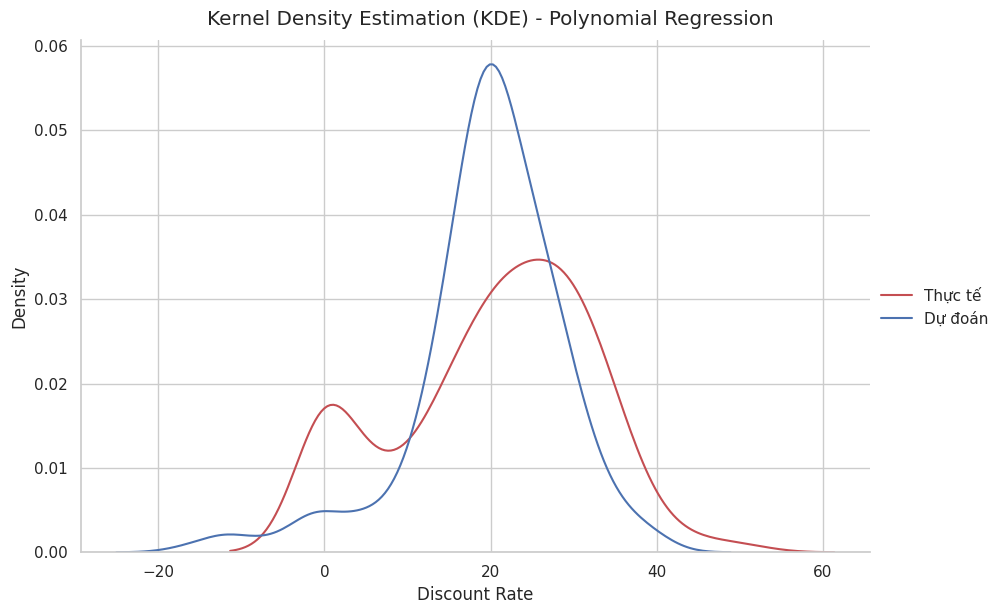

In [ ]:
g = sns.FacetGrid(pd.DataFrame({'Thực tế':y_test, 'Dự đoán': poly_pred}), height=6, aspect=1.5)

g.map(sns.kdeplot, 'Thực tế', color='r', label='Thực tế')
g.map(sns.kdeplot, 'Dự đoán', color='b', label='Dự đoán')
g.set_axis_labels('Discount Rate', 'Density')
g.fig.suptitle('Kernel Density Estimation (KDE) - Polynomial Regression', y=1.02)

g.add_legend()
plt.show()


## 5.Polynomial Ridge Regression

In [ ]:
model = make_pipeline(PolynomialFeatures(), Ridge())

# Thiết lập các tham số cần tìm kiếm
param_grid = {'polynomialfeatures__degree': np.arange(1, 7)}

# Sử dụng GridSearchCV để tìm độ cao tối ưu
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(x_train, y_train)

# In độ cao tối ưu và điểm số tương ứng
best_degree = grid_search.best_params_['polynomialfeatures__degree']
best_score = -grid_search.best_score_
print(f'Best Degree: {best_degree}')
print(f'Best Mean Squared Error on Training Set: {best_score}')

poly_rr_train = grid_search.predict(x_train)
poly_rr_pred = grid_search.predict(x_test)

Best Degree: 2
Best Mean Squared Error on Training Set: 40.73701391294607


In [ ]:
poly_rr_eval = evaluate_model(y_test, poly_rr_pred)
print("Polynomial Ridge Regression:\n")
print('Đánh giá trên tập train:')
print_score(evaluate_model(y_train, poly_rr_train))
print('====================================\n')
print('Đánh giá trên tập test:')
print_score(poly_rr_eval)

Polynomial Ridge Regression:

Đánh giá trên tập train:
    MAE: 3.76
    MSE: 30.73
    RMSE: 5.54
    R-squared: 0.7920
    RMSLE: 0.47
    MAPE: inf%

Đánh giá trên tập test:
    MAE: 3.52
    MSE: 28.24
    RMSE: 5.31
    R-squared: 0.7941
    RMSLE: 0.46
    MAPE: inf%


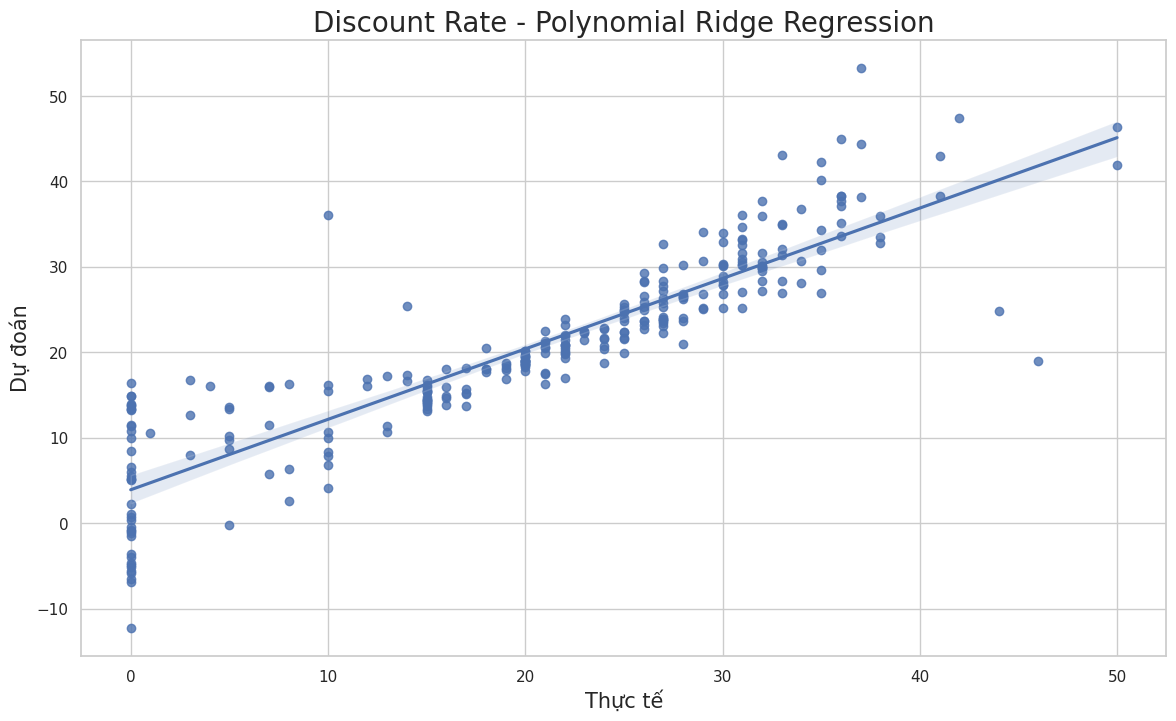

In [ ]:
out=pd.DataFrame({'Thực tế':y_test,'Dự đoán':poly_rr_pred})
result=df1.merge(out,left_index=True,right_index=True)

plt.figure(figsize=(14,8))
sns.regplot(x='Thực tế',y='Dự đoán',data=result)
plt.title('Discount Rate - Polynomial Ridge Regression',fontsize=20)
plt.xlabel('Thực tế',fontsize=15)
plt.ylabel('Dự đoán',fontsize=15)
plt.show()

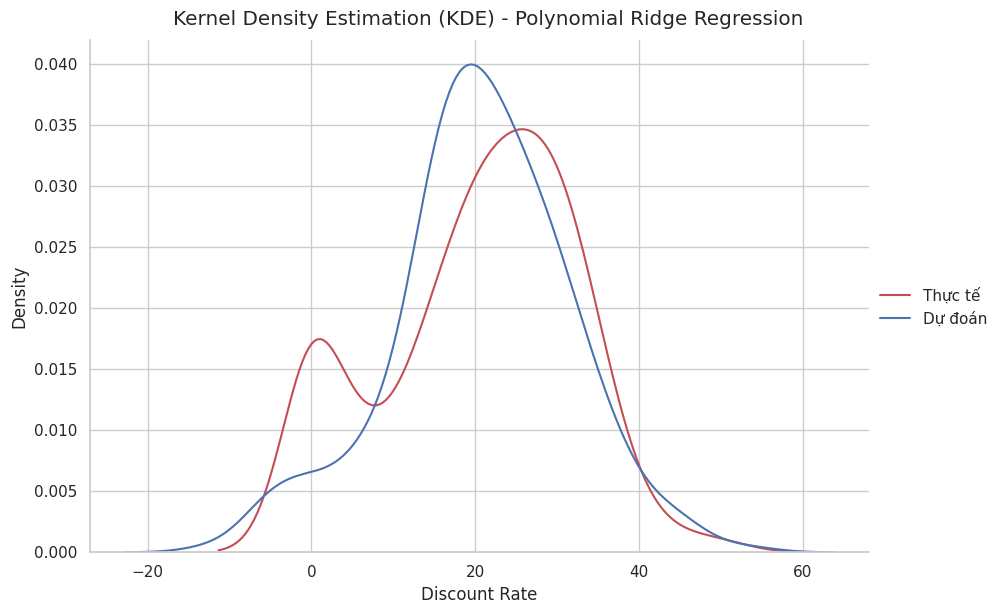

In [ ]:
pd.DataFrame({'Error values': (y_test - poly_rr_pred)}).hvplot.kde()
g = sns.FacetGrid(pd.DataFrame({'Giá trị thực':y_test, 'Dự đoán': poly_rr_pred}), height=6, aspect=1.5)

g.map(sns.kdeplot, 'Giá trị thực', color='r', label='Thực tế')
g.map(sns.kdeplot, 'Dự đoán', color='b', label='Dự đoán')
g.set_axis_labels('Discount Rate', 'Density')
g.fig.suptitle('Kernel Density Estimation (KDE) - Polynomial Ridge Regression', y=1.02)

g.add_legend()
plt.show()


## 6.Polynomial Lasso Regression

In [ ]:
model = make_pipeline(PolynomialFeatures(), Lasso())

# Thiết lập các tham số cần tìm kiếm
param_grid = {'polynomialfeatures__degree': np.arange(1, 7)}

# Sử dụng GridSearchCV để tìm độ cao tối ưu
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(x_train, y_train)

# In độ cao tối ưu và điểm số tương ứng
best_degree = grid_search.best_params_['polynomialfeatures__degree']
best_score = -grid_search.best_score_
print(f'Best Degree: {best_degree}')
print(f'Best Mean Squared Error on Training Set: {best_score}')
poly_lar_train=grid_search.predict(x_train)
poly_lar_pred=grid_search.predict(x_test)

Best Degree: 2
Best Mean Squared Error on Training Set: 42.53852010741515


In [ ]:
poly_lar_eval = evaluate_model(y_test, poly_lar_pred)
print("Polynomial Lasso Regression:\n")
print('Đánh giá trên tập train:')
print_score(evaluate_model(y_train, poly_lar_train))
print('====================================\n')
print('Đánh giá trên tập test:')
print_score(poly_lar_eval)

Polynomial Lasso Regression:

Đánh giá trên tập train:
    MAE: 3.75
    MSE: 30.80
    RMSE: 5.55
    R-squared: 0.7915
    RMSLE: 0.47
    MAPE: inf%

Đánh giá trên tập test:
    MAE: 3.53
    MSE: 28.56
    RMSE: 5.34
    R-squared: 0.7918
    RMSLE: 0.45
    MAPE: inf%


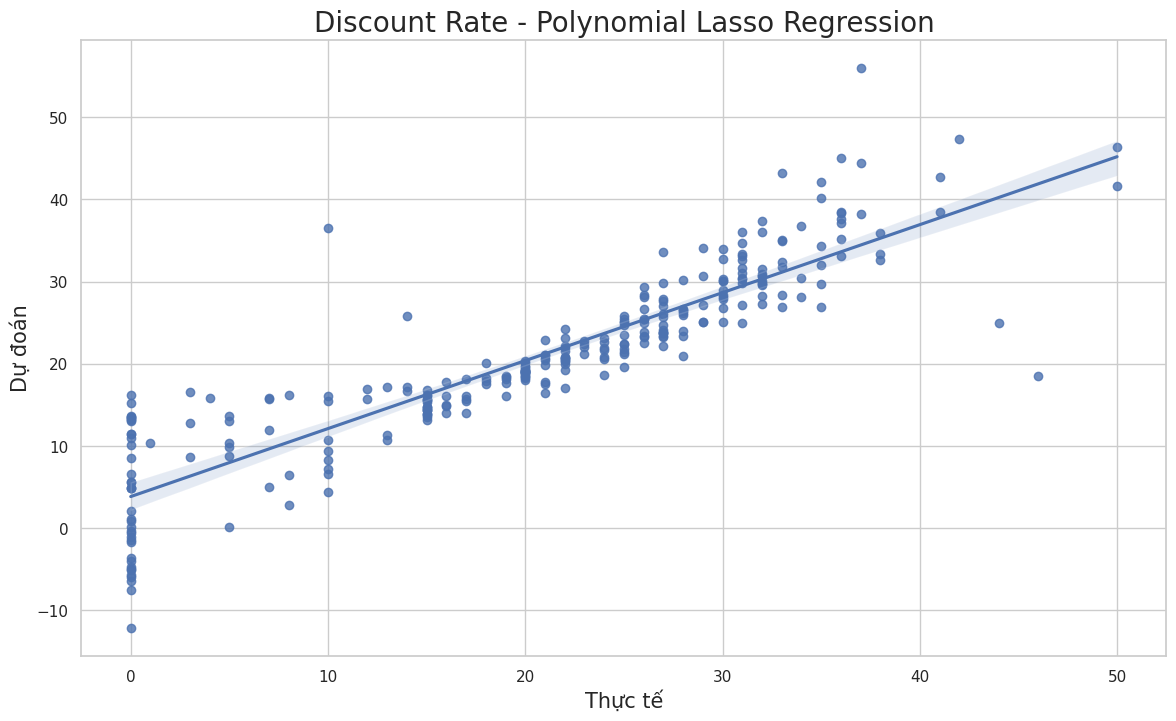

In [ ]:
out=pd.DataFrame({'Thực tế':y_test,'Dự đoán':poly_lar_pred})
result=df1.merge(out,left_index=True,right_index=True)

plt.figure(figsize=(14,8))
sns.regplot(x='Thực tế',y='Dự đoán',data=result)
plt.title('Discount Rate - Polynomial Lasso Regression',fontsize=20)
plt.xlabel('Thực tế',fontsize=15)
plt.ylabel('Dự đoán',fontsize=15)
plt.show()

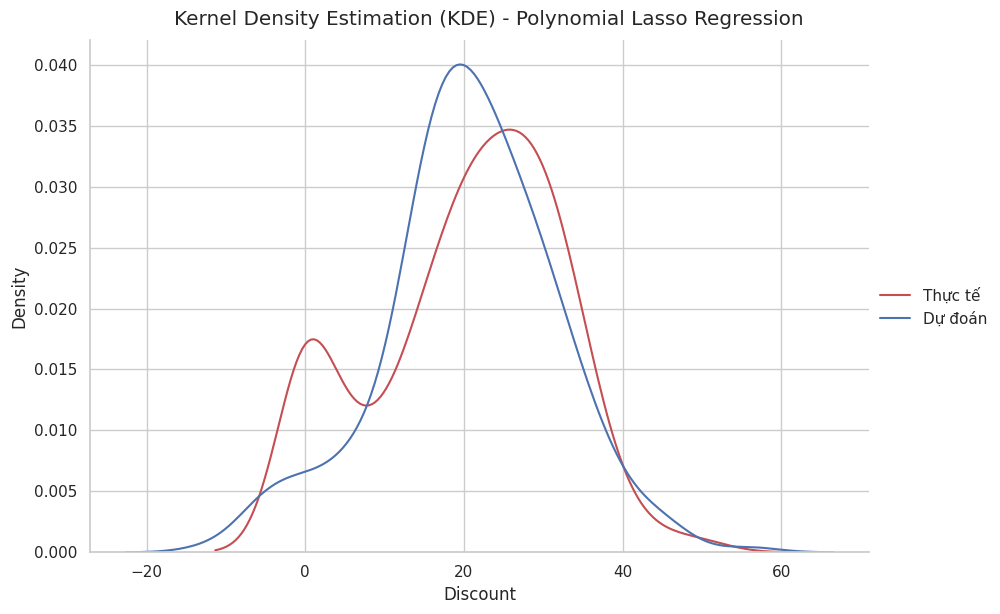

In [ ]:
pd.DataFrame({'Error values': (y_test - poly_lar_pred)}).hvplot.kde()
g = sns.FacetGrid(pd.DataFrame({'Giá trị thực':y_test, 'Dự đoán': poly_lar_pred}), height=6, aspect=1.5)

g.map(sns.kdeplot, 'Giá trị thực', color='r', label='Thực tế')
g.map(sns.kdeplot, 'Dự đoán', color='b', label='Dự đoán')
g.set_axis_labels('Discount', 'Density')
g.fig.suptitle('Kernel Density Estimation (KDE) - Polynomial Lasso Regression', y=1.02)

g.add_legend()
plt.show()

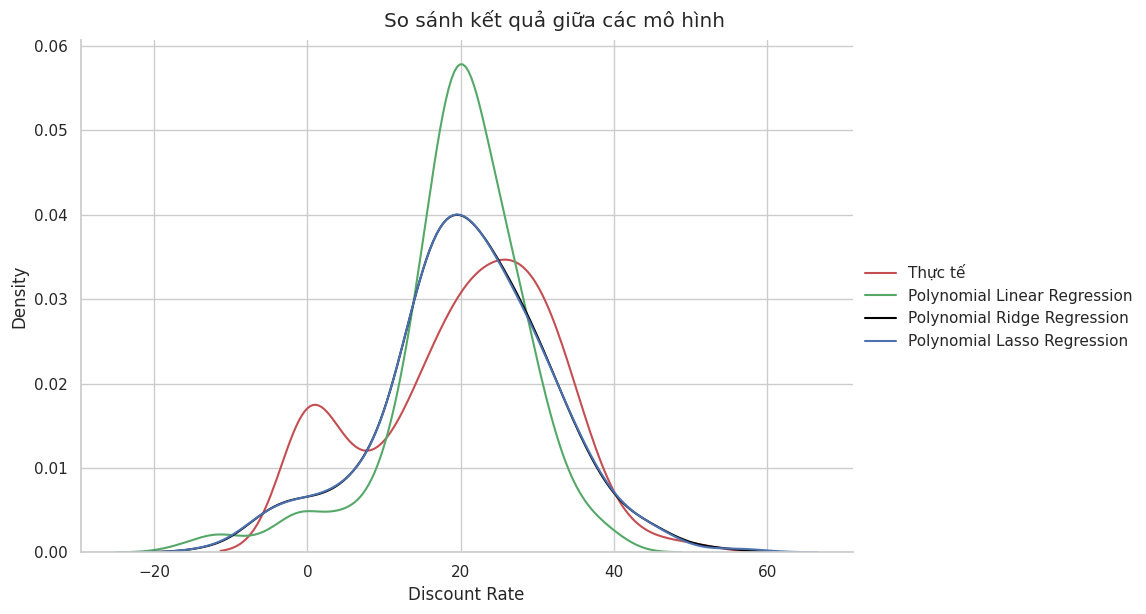

In [ ]:
g = sns.FacetGrid(pd.DataFrame({'Giá trị thực':y_test,'Linear':poly_pred,  'Rigde': poly_rr_pred,'Lasso': poly_lar_pred }), height=6, aspect=1.5)

g.map(sns.kdeplot, 'Giá trị thực', color='r', label='Thực tế')
g.map(sns.kdeplot, 'Linear', color='g', label='Polynomial Linear Regression')
g.map(sns.kdeplot, 'Rigde', color='black', label='Polynomial Ridge Regression')
g.map(sns.kdeplot, 'Lasso', color='b', label='Polynomial Lasso Regression')
g.set_axis_labels('Discount Rate', 'Density')
g.fig.suptitle('So sánh kết quả giữa các mô hình', y=1.02)

g.add_legend()
plt.show()

## 7.KNN Regressor

In [ ]:
param_grid = {'n_neighbors': [1, 3, 5, 7, 9], 'weights': ['uniform', 'distance']}
knn_model = KNeighborsRegressor()
grid_search = GridSearchCV(knn_model, param_grid, scoring='r2', cv=5)
grid_search.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': [1, 3, 5, 7, 9],
                         'weights': ['uniform', 'distance']},
             scoring='r2')

In [ ]:
print("Tham số tốt nhất: ", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

Tham số tốt nhất:  {'n_neighbors': 3, 'weights': 'distance'}
Best cross-validation score: 0.95


In [ ]:
knn_pred_train=grid_search.predict(x_train)
knn_pred=grid_search.predict(x_test)

In [ ]:
knn_eval = evaluate_model(y_test, knn_pred)
print("KNeighbors Regression:\n")
print('Đánh giá trên tập train:')
print_score(evaluate_model(y_train, knn_pred_train))
print('====================================\n')
print('Đánh giá trên tập test:')
print_score(knn_eval)

KNeighbors Regression:

Đánh giá trên tập train:
    MAE: 0.00
    MSE: 0.00
    RMSE: 0.00
    R-squared: 1.0000
    RMSLE: 0.00
    MAPE: 0.00%

Đánh giá trên tập test:
    MAE: 0.64
    MSE: 1.42
    RMSE: 1.19
    R-squared: 0.9896
    RMSLE: 0.13
    MAPE: inf%


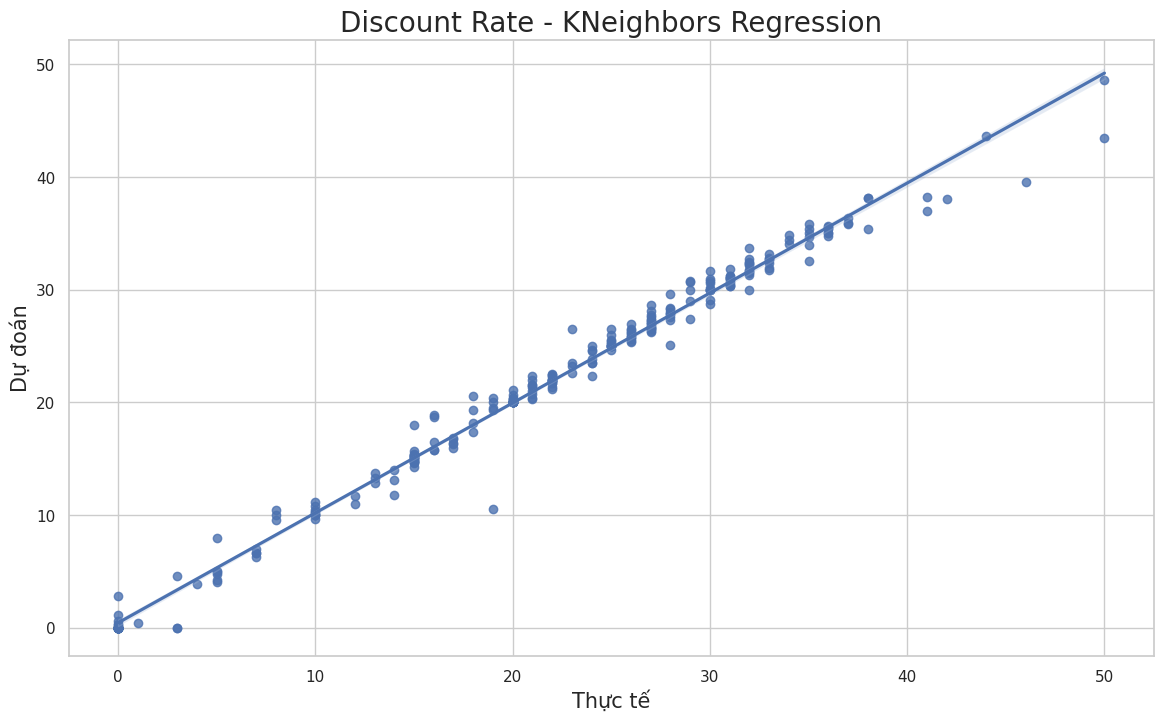

In [ ]:
out=pd.DataFrame({'Thực tế':y_test,'Dự đoán':knn_pred})
result=df.merge(out,left_index=True,right_index=True)

plt.figure(figsize=(14,8))
sns.regplot(x='Thực tế',y='Dự đoán',data=result)
plt.title('Discount Rate - KNeighbors Regression',fontsize=20)
plt.xlabel('Thực tế',fontsize=15)
plt.ylabel('Dự đoán',fontsize=15)
plt.show()

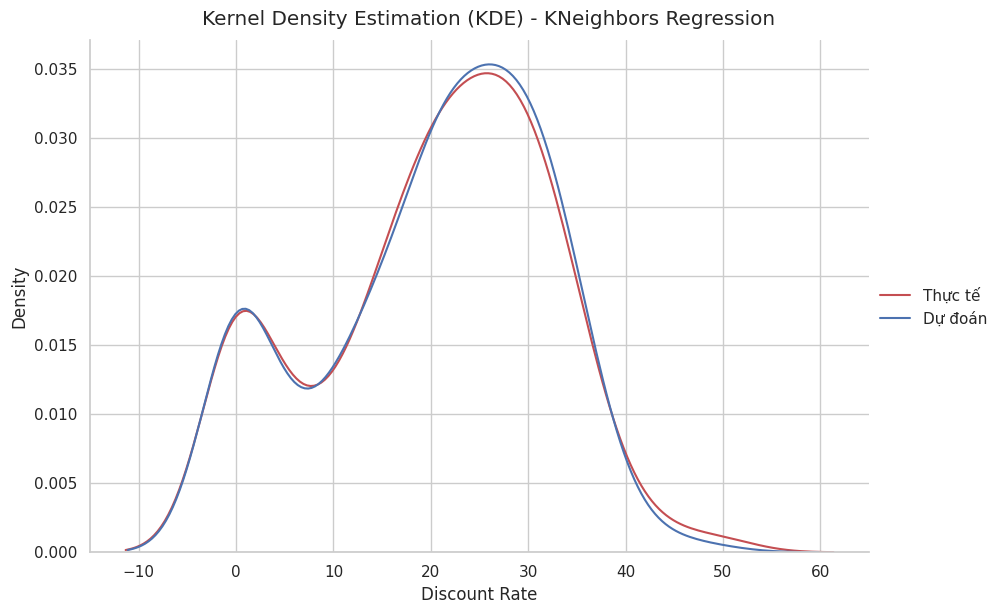

In [ ]:
g = sns.FacetGrid(pd.DataFrame({'Giá trị thực':y_test, 'Dự đoán': knn_pred}), height=6, aspect=1.5)

g.map(sns.kdeplot, 'Giá trị thực', color='r', label='Thực tế')
g.map(sns.kdeplot, 'Dự đoán', color='b', label='Dự đoán')
g.set_axis_labels('Discount Rate', 'Density')
g.fig.suptitle('Kernel Density Estimation (KDE) - KNeighbors Regression', y=1.02)

g.add_legend()
plt.show()


## 8.Random Forest Regression

In [ ]:
rf_model = RandomForestRegressor()

# Tìm hệ số tối ưu
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(rf_model, param_grid, scoring='r2', cv=5)
grid_search.fit(x_train,y_train)
best_params = grid_search.best_params_
print('Các giá trị tốt nhất của các tham số: ',best_params)
rf_pred_train=grid_search.predict(x_train)
rf_pred=grid_search.predict(x_test)

Các giá trị tốt nhất của các tham số:  {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [ ]:
# Kết quả trên tập test
rf_eval = evaluate_model(y_test, rf_pred)
print("RandomForestRegressor:\n")
print('Đánh giá trên tập train:')
print_score(evaluate_model(y_train, rf_pred_train))
print('====================================\n')
print('Đánh giá trên tập test:')
print_score(knn_eval)

RandomForestRegressor:

Đánh giá trên tập train:
    MAE: 0.33
    MSE: 0.54
    RMSE: 0.73
    R-squared: 0.9964
    RMSLE: 0.04
    MAPE: inf%

Đánh giá trên tập test:
    MAE: 0.64
    MSE: 1.42
    RMSE: 1.19
    R-squared: 0.9896
    RMSLE: 0.13
    MAPE: inf%


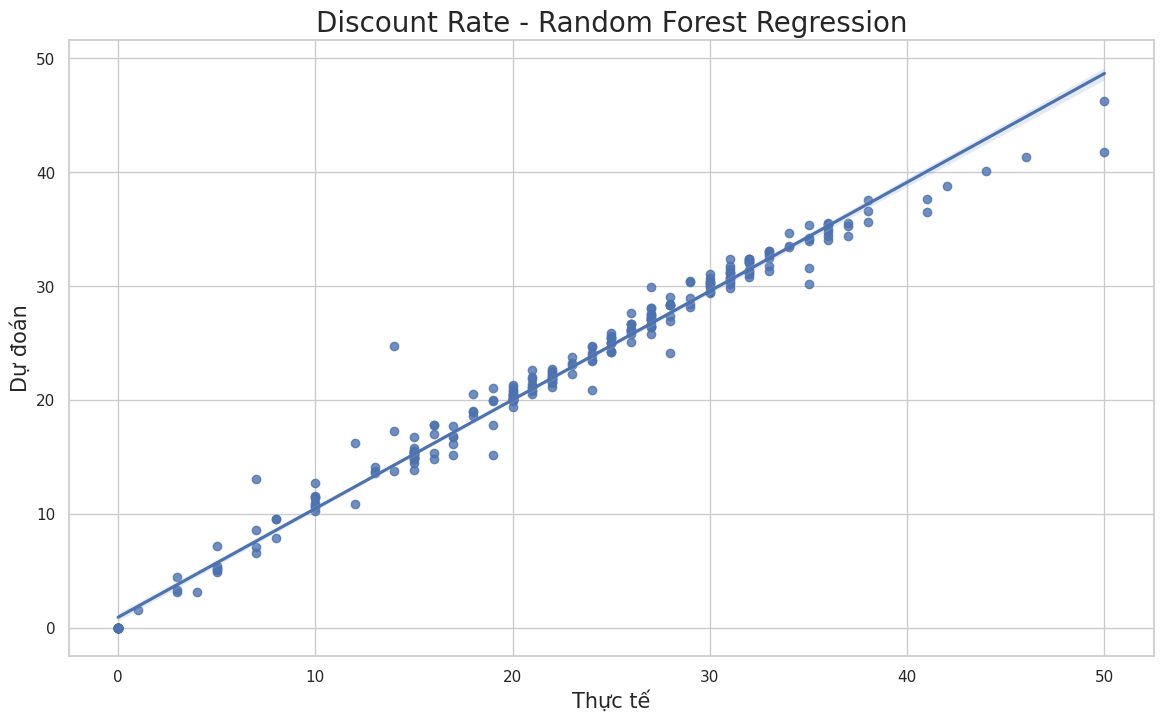

In [ ]:
out=pd.DataFrame({'Thực tế':y_test,'Dự đoán':rf_pred})
result=df.merge(out,left_index=True,right_index=True)

plt.figure(figsize=(14,8))
sns.regplot(x='Thực tế',y='Dự đoán',data=result)
plt.title('Discount Rate - Random Forest Regression',fontsize=20)
plt.xlabel('Thực tế',fontsize=15)
plt.ylabel('Dự đoán',fontsize=15)
plt.show()

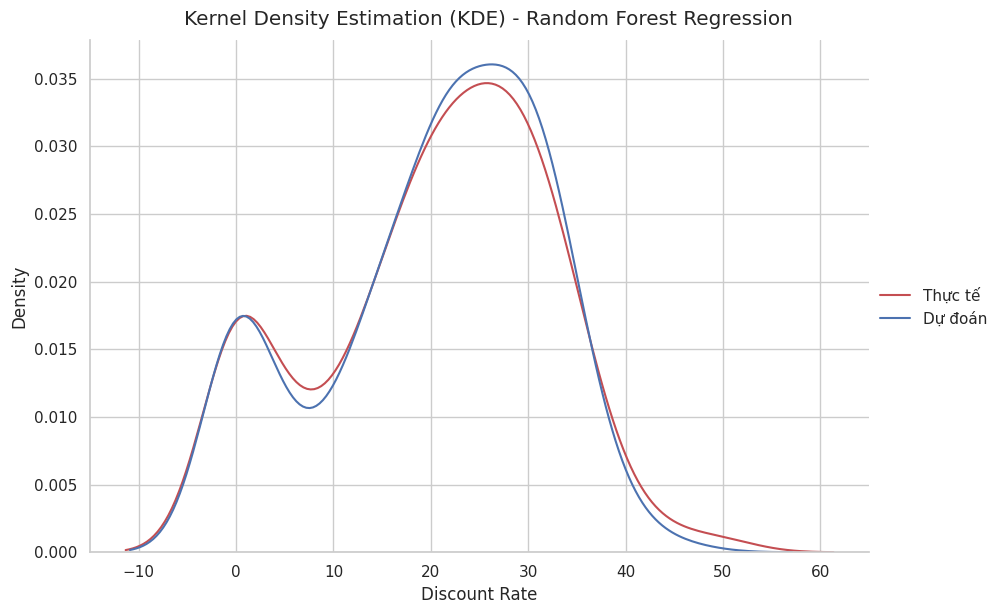

In [ ]:
g= sns.FacetGrid(pd.DataFrame({'Giá trị thực':y_test, 'Dự đoán': rf_pred}), height=6, aspect=1.5)

g.map(sns.kdeplot, 'Giá trị thực', color='r', label='Thực tế')
g.map(sns.kdeplot, 'Dự đoán', color='b', label='Dự đoán')
g.set_axis_labels('Discount Rate', 'Density')
g.fig.suptitle('Kernel Density Estimation (KDE) - Random Forest Regression', y=1.02)

g.add_legend()
plt.show()


## 9.So sánh kết quả giữa các mô hình

In [ ]:
col=['MAE','MSE','RMSE','R-squared','RMSLE','MAPE']
lr_score = pd.DataFrame(data = [lr_eval], columns=col)
lr_score.insert(0, 'Model', 'Linear Regression')
rr_score = pd.DataFrame(data = [rr_eval], columns=col)
rr_score.insert(0, 'Model', 'Ridge Regression')
lar_score = pd.DataFrame(data = [lar_eval], columns=col)
lar_score.insert(0, 'Model', 'Lasso Regression')
poly_lr_score = pd.DataFrame(data = [poly_eval], columns=col)
poly_lr_score.insert(0, 'Model', 'Polynomial Linear Regression')
poly_rr_score = pd.DataFrame(data = [poly_rr_eval], columns=col)
poly_rr_score.insert(0, 'Model', 'Polynomial Ridge Regression')
poly_lar_score = pd.DataFrame(data = [poly_lar_eval], columns=col)
poly_lar_score.insert(0, 'Model', 'Polynomial Lasso Regression')
knn_score = pd.DataFrame(data = [knn_eval], columns=col)
knn_score.insert(0, 'Model', 'KNeighbors Regression')
rf_score = pd.DataFrame(data = [rf_eval], columns=col)
rf_score.insert(0, 'Model', 'Random Forest Regression')

predictions = pd.concat([lr_score, rr_score, lar_score, poly_lr_score, poly_rr_score, poly_lar_score, knn_score, rf_score],ignore_index=True ,sort=False)
predictions

Model       MAE        MSE      RMSE  R-squared     RMSLE      MAPE
0  Linear Regression             4.859774  46.728593  6.835832  0.659353   0.517158  inf     
1  Ridge Regression              4.887458  47.011502  6.856493  0.657291   0.517733  inf     
2  Lasso Regression              4.879250  46.839173  6.843915  0.658547   0.516158  inf     
3  Polynomial Linear Regression  4.879215  46.838338  6.843854  0.658553   0.516149  inf     
4  Polynomial Ridge Regression   3.520319  28.244599  5.314565  0.794100   0.462696  inf     
5  Polynomial Lasso Regression   3.533412  28.561809  5.344325  0.791787   0.451345  inf     
6  KNeighbors Regression         0.641948  1.421000   1.192057  0.989641   0.133847  inf     
7  Random Forest Regression      0.778333  2.038179   1.427648  0.985142   0.073505  5.117098

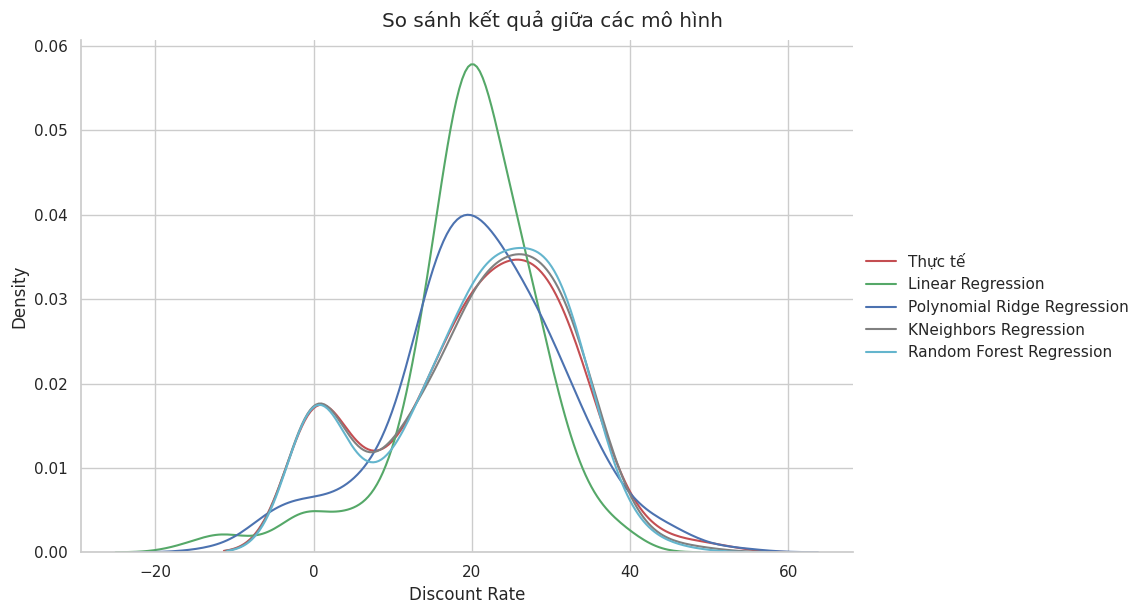

In [ ]:
g = sns.FacetGrid(pd.DataFrame({'Giá trị thực':y_test,'Linear':poly_pred,  'Rigde': poly_rr_pred,'knn': knn_pred, 'rf': rf_pred }), height=6, aspect=1.5)

g.map(sns.kdeplot, 'Giá trị thực', color='r', label='Thực tế')
g.map(sns.kdeplot, 'Linear', color='g', label='Linear Regression')
g.map(sns.kdeplot, 'Rigde', color='b', label='Polynomial Ridge Regression')
g.map(sns.kdeplot, 'knn', color='gray', label='KNeighbors Regression')
g.map(sns.kdeplot, 'rf', color='c', label='Random Forest Regression')
g.set_axis_labels('Discount Rate', 'Density')
g.fig.suptitle('So sánh kết quả giữa các mô hình', y=1.02)

g.add_legend()
plt.show()
